# Genetic Analysis of a Metazoan Pathway using Transcriptomic Phenotypes Supplementary and Extended Material
**David Angeles-Albores, Carmie Puckett Robinson, Brian Williams, Igot Antoshechkin, and Paul W Sternberg**

The purpose of this notebook is to serve as an extended, interactive document for our [paper](http://www.wormbase.org/).

All code in this notebook was written, documented and generated by David Angeles-Albores. In cases when code was inspired, written or shown elsewhere first, links have been provided to the source material where possible.

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Genetic-Analysis-of-a-Metazoan-Pathway-using-Transcriptomic-Phenotypes-Supplementary-and-Extended-Material" data-toc-modified-id="Genetic-Analysis-of-a-Metazoan-Pathway-using-Transcriptomic-Phenotypes-Supplementary-and-Extended-Material-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Genetic Analysis of a Metazoan Pathway using Transcriptomic Phenotypes Supplementary and Extended Material</a></div><div class="lev1 toc-item"><a href="#Folder-Structure" data-toc-modified-id="Folder-Structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Folder Structure</a></div><div class="lev1 toc-item"><a href="#Read-alignment-and-differential-expression-analysis" data-toc-modified-id="Read-alignment-and-differential-expression-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read alignment and differential expression analysis</a></div><div class="lev1 toc-item"><a href="#Introduction:-Genetic-Analysis-Using-Global-Expression-Measurements" data-toc-modified-id="Introduction:-Genetic-Analysis-Using-Global-Expression-Measurements-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Introduction: Genetic Analysis Using Global Expression Measurements</a></div><div class="lev2 toc-item"><a href="#PCA-Analysis-of-TPM-Data" data-toc-modified-id="PCA-Analysis-of-TPM-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PCA Analysis of TPM Data</a></div><div class="lev1 toc-item"><a href="#Figure-1.-Dendrogram-Clustering" data-toc-modified-id="Figure-1.-Dendrogram-Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 1. Dendrogram Clustering</a></div><div class="lev2 toc-item"><a href="#Filtering-Does-Not-Seriously-Alter-Differentially-Expressed-Genes" data-toc-modified-id="Filtering-Does-Not-Seriously-Alter-Differentially-Expressed-Genes-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Filtering Does Not Seriously Alter Differentially Expressed Genes</a></div><div class="lev1 toc-item"><a href="#Bayesian-versus-Spearman-Regressions" data-toc-modified-id="Bayesian-versus-Spearman-Regressions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Bayesian versus Spearman Regressions</a></div><div class="lev2 toc-item"><a href="#Spearman-Regression-Method" data-toc-modified-id="Spearman-Regression-Method-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Spearman Regression Method</a></div><div class="lev2 toc-item"><a href="#Bayesian-Robust-Regression" data-toc-modified-id="Bayesian-Robust-Regression-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Bayesian Robust Regression</a></div><div class="lev2 toc-item"><a href="#Figure-4.-Complex-Regulation-Generates-Detectable-Patterns-in-Transcriptomes" data-toc-modified-id="Figure-4.-Complex-Regulation-Generates-Detectable-Patterns-in-Transcriptomes-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Figure 4. Complex Regulation Generates Detectable Patterns in Transcriptomes</a></div><div class="lev2 toc-item"><a href="#Figure-2.-Positive-Regulatory-Relationships-Can-Be-Identified-By-Transcriptomic-Correlation" data-toc-modified-id="Figure-2.-Positive-Regulatory-Relationships-Can-Be-Identified-By-Transcriptomic-Correlation-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Figure 2. Positive Regulatory Relationships Can Be Identified By Transcriptomic Correlation</a></div><div class="lev1 toc-item"><a href="#Pairwise-Analysis-of-All-Genes-Using-Spearman-Correlation" data-toc-modified-id="Pairwise-Analysis-of-All-Genes-Using-Spearman-Correlation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Pairwise Analysis of All Genes Using Spearman Correlation</a></div><div class="lev1 toc-item"><a href="#Hypergeometric-Analysis:" data-toc-modified-id="Hypergeometric-Analysis:-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Hypergeometric Analysis:</a></div><div class="lev1 toc-item"><a href="#Analysis-Using-Robust-Spearman-Regression" data-toc-modified-id="Analysis-Using-Robust-Spearman-Regression-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Analysis Using Robust Spearman Regression</a></div><div class="lev1 toc-item"><a href="#Double-Mutant-Analysis" data-toc-modified-id="Double-Mutant-Analysis-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Double Mutant Analysis</a></div><div class="lev1 toc-item"><a href="#Defining-the-Hypoxia-Response" data-toc-modified-id="Defining-the-Hypoxia-Response-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Defining the Hypoxia Response</a></div><div class="lev1 toc-item"><a href="#The-genes-upregulated-by-egl-9-should-be-down-in-Hif-1." data-toc-modified-id="The-genes-upregulated-by-egl-9-should-be-down-in-Hif-1.-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>The genes upregulated by egl-9 should be down in Hif-1.</a></div><div class="lev1 toc-item"><a href="#Tissue-and-Phenotype-Enrichment-Analyses:" data-toc-modified-id="Tissue-and-Phenotype-Enrichment-Analyses:-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Tissue and Phenotype Enrichment Analyses:</a></div><div class="lev1 toc-item"><a href="#Quality-Control" data-toc-modified-id="Quality-Control-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Quality Control</a></div><div class="lev1 toc-item"><a href="#An-in-silico-qPCR-experiment:" data-toc-modified-id="An-in-silico-qPCR-experiment:-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>An <em>in silico</em> qPCR experiment:</a></div><div class="lev1 toc-item"><a href="#Define-the-Absolute-Gold-Set" data-toc-modified-id="Define-the-Absolute-Gold-Set-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Define the Absolute Gold Set</a></div><div class="lev1 toc-item"><a href="#Hypoxia-Positive-Interaction" data-toc-modified-id="Hypoxia-Positive-Interaction-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Hypoxia Positive Interaction</a></div><div class="lev1 toc-item"><a href="#Searching-for-a-TF-that-is-activated-by-both-egl-9-and-hif-1" data-toc-modified-id="Searching-for-a-TF-that-is-activated-by-both-egl-9-and-hif-1-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Searching for a TF that is activated by both egl-9 and hif-1</a></div>

# Folder Structure

The folder structure is a little bit important if you want to replicate the findings presented here. 

Briefly, the folder structure is contained in the following major folders:

 * input - contains raw FASTQ files, kallisto_all (processed reads), genmap file, TF list, cDNA file, transcripts.idx, enrichment dictionaries and hypoxia gold standard gene files
 * sleuth - contains differential analysis (no *fog-2* included) results
 * sleuth_batch_adjusted - contains differential analysis results with *fog-2* included
 * src - all python scripts
 * output - all figures
 * tex - manuscript
 * experimental_docs - all bioanalyzer results are placed here

# Read alignment and differential expression analysis

 The raw FASTQ reads are in input/rawseq/PROJECT_NAME/. These reads are processed by running **kallisto_bash_generator.py**, then from terminal (in the main directory) *chmod +x kallisto commands.sh; sh kallisto_commands.sh*. Reads were processed using a length of **180**bp, with a standard deviation of **60** basepairs, bootstrapped 200 times. The results from this analysis are then placed in input/kallisto_all/PROJECT_NAME/.
 
 Sleuth analysis was performed by running **Sleuth_Prep.py**, then **Sleuth_Command_Writer.py** which generates the folder *sleuth/*. After writing the **diff_exp_analyzer.R** and placing it within the sleuth folder, navigate to sleuth folder using terminal, then type *chmod +x sleuth_commands.sh*, then *sh sleut_commands.sh*. This will perform the differential expression analysis. The results are stored in folders named WT_X, where X is the genotype being compared to wild-type. 
 
 

# Introduction: Genetic Analysis Using Global Expression Measurements

The following sections will provide (excruciating) detail on how we performed the genetic analysis of our mutants using this data. Initially, this analysis was done blindly. For clarity, I have added all the genotype identifiers from the beginning.

To start, we should load all the python libraries that we will need:

In [27]:
# important stuff:
import os
import pandas as pd
import numpy as np

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# bayes and mcmc
import pymc3 as pm
import theano

# Display graphics in this notebook
bokeh.io.output_notebook()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize

Loading BokehJS ...

Next, I need to load the **phenotype_df** (please don't use this file without permission for publication purposes. This tool is unpublished [I am actively working on a paper with this] and will be available soon. I provide it here for clarity, even though it was not part of our paper), the **tissue_df** and the **tf_df**. These files contains a phenotype-gene dictionary, a tissue-gene dictionary (downloaded from TEA) and a transcription factor list (from Chris Grove). 

Additionally, I will initialize several variables whose purpose will mainly be to prettify the tables and substitute in the correct names. 

In [4]:
phenotype_df = pd.read_csv('../input/dictionaries/phenotype_dictionary.csv')
tissue_df = tea.fetch_dictionary()
tf_df = pd.read_csv('../input/tf_list.csv')

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sort_pairs = {'eb': 1, 'be': 1,
              'ed': 2,'de': 2,
              'ec': 3,'ce': 3,
              'eg': 4,'ge': 4,
              'bd': 5,'db': 5,
              'cb': 6,'bc': 6,
              'bg': 7, 'gb': 7,
              'cd': 8,'dc': 8,
              'dg': 9,'gd': 9,
              'cg': 10,'gc': 10
             }

decode_pairs = {'eb': '\emph{rhy-1}, \emph{egl-9}', 'be': '\emph{rhy-1}, \emph{egl-9}',
              'ed': '\emph{rhy-1}, \emph{vhl-1}','de': '\emph{rhy-1}, \emph{vhl-1}',
              'ec': '\emph{rhy-1}, \emph{hif-1}','ce': '\emph{rhy-1}, \emph{hif-1}',
              'eg': '\emph{rhy-1}, \emph{fog-2}','ge': '\emph{rhy-1}, \emph{fog-2}',
              'bd': '\emph{egl-9}, \emph{vhl-1}','db': '\emph{egl-9}, \emph{vhl-1}',
              'cb': '\emph{egl-9}, \emph{hif-1}','bc': '\emph{egl-9}, \emph{hif-1}',
              'bg': '\emph{egl-9}, \emph{fog-2}', 'gb': '\emph{egl-9}, \emph{fog-2}',
              'cd': '\emph{vhl-1}, \emph{hif-1}','dc': '\emph{vhl-1}, \emph{hif-1}',
              'dg': '\emph{hif-1}, \emph{fog-2}','gd': '\emph{vhl-1}, \emph{fog-2}',
              'cg': '\emph{hif-1}, \emph{fog-2}','gc': '\emph{hif-1}, \emph{fog-2}'
             }

Next, we will load up all of our files. These files will be placed within a class called morgan.hunt (funny!). All of the classes that are referenced in this tutorial are in the file morgan.py, which you are welcome to use for your own analysis. The classes are relatively well-documented and should be usable if you are careful. That said, I am not a computer scientist, so some pathologies or bugs may pop up -- if they do, please perform a pull-request on our github with a fix for the bug. Alternatively, please email me a sufficiently detailed script so I can reconstruct the failure event and correct the bug.

In [35]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e']
# Specify which genotypes are double mutants and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'
thomas.add_betas(sleuth_loc, 'betas.csv', combs)

Next, I will filter the data, removing any genes that don't show up in all the files and removing the bottom 10% of the genes by expression level. This is an aggressive cutoff, I know. 

In [36]:
thomas.filter_data(0, 0.1)

Number of na genes: 983


## PCA Analysis of TPM Data

PCA analysis of TPM data should hopefully reveal some structure and clustering in this dataset and show us that this isn't pointless immediately. 

First, I want to know how many PCs explain >90% of the data, then build a PCA object with that
many dimensions which I will use for agglomerative clustering. 

In [44]:
# PCA
#exclude g
pca_matrix = genpy.make_matrix(thomas.tpm, thomas.genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 4 principal components explain >=90% of the data


In [45]:
# keep only the first principal components that explain 90% of the data
if n < 3:
    n = 3

df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = thomas.genmap.project_name.unique()
l = lambda x: thomas.genmap[thomas.genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,PCA4,samples,genotypes
0,-7597.070087,-2748.583552,-3246.871740,1290.455581,Project_17434_indexN704-N517,wt
1,11507.253519,-2051.481912,-1497.092629,-3054.503202,Project_17441_indexN704-N508,a
2,-3499.905323,5120.560035,-2885.212424,3672.694861,Project_17448_indexN705-N507,d
3,-7673.426882,-2525.724491,-1947.520648,5304.474756,Project_17435_indexN704-N502,wt
4,10090.924838,-3448.230513,-2854.242845,-456.802389,Project_17442_indexN705-N517,a


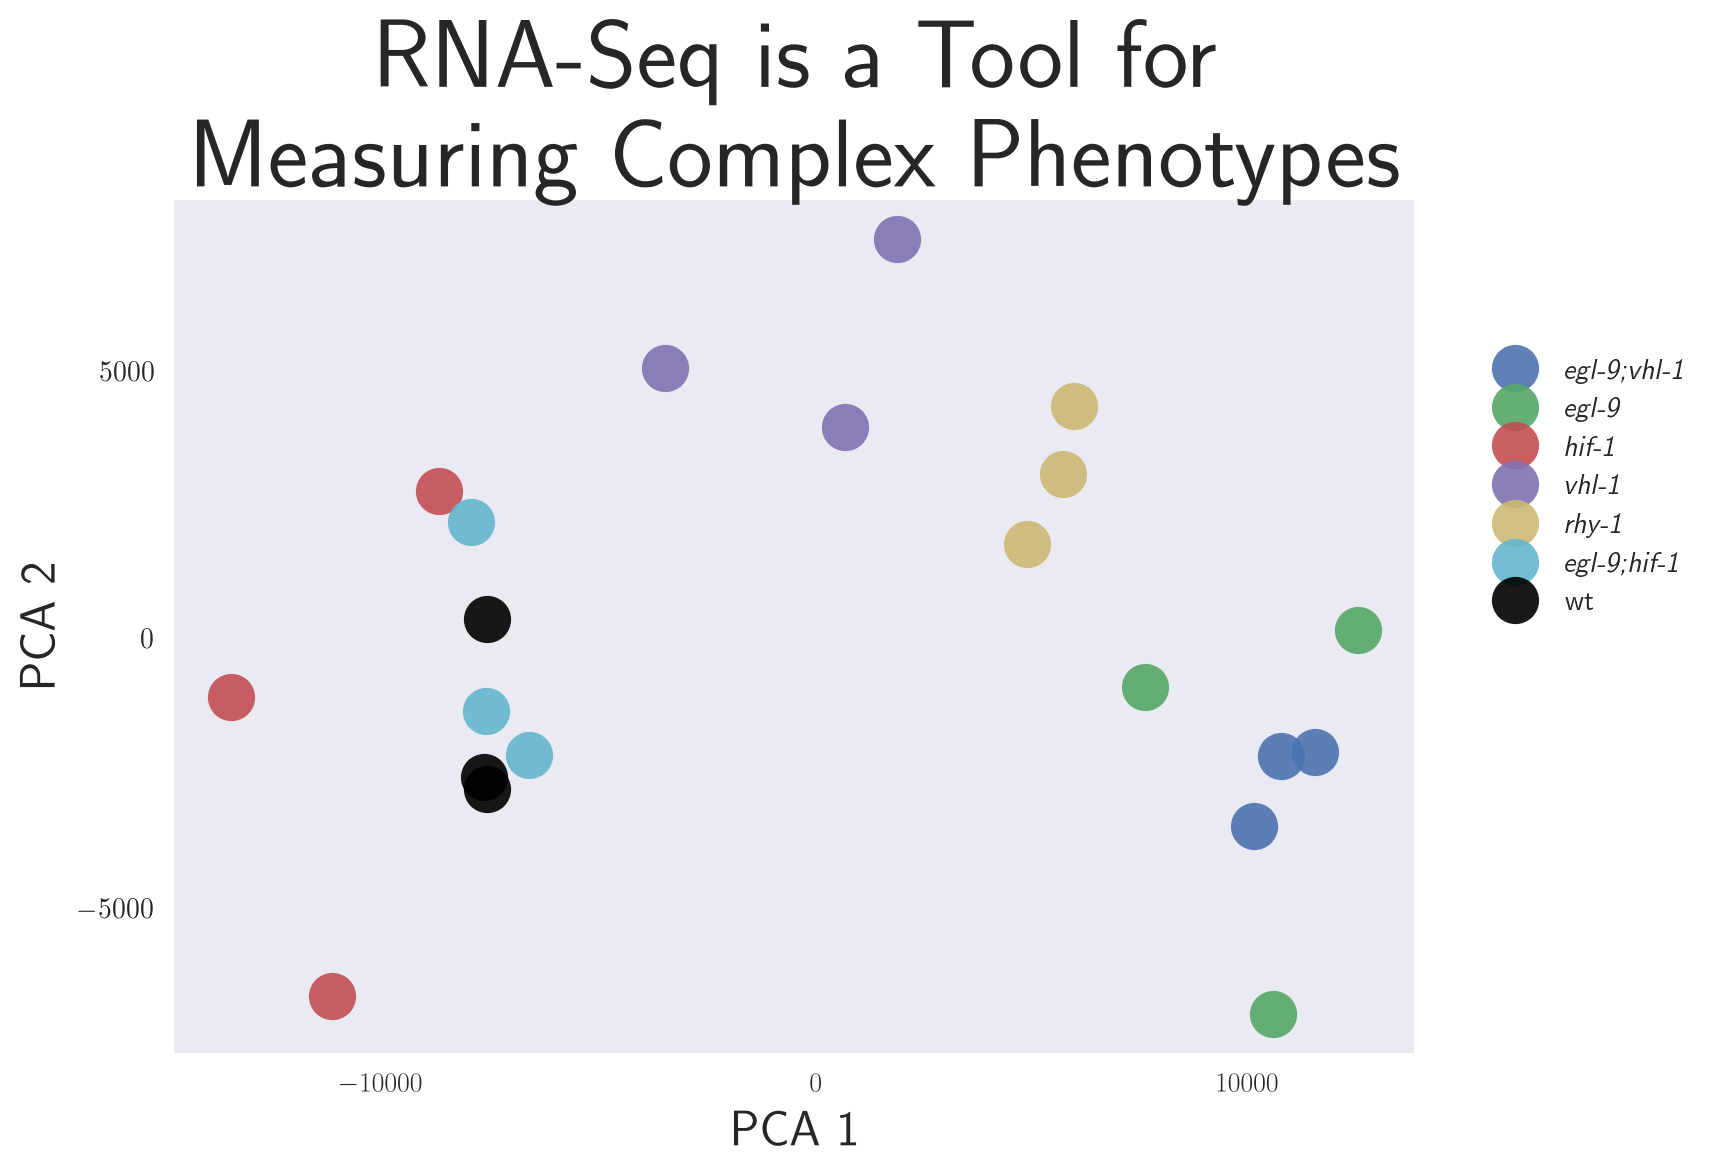

In [46]:
def plot_2d_pca(df_pca, group_col, special_key, double_mutant_hash= {},save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key in genotype_mapping.keys():
            lab = genotype_mapping[key]
        else:
            lab = key
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=lab, ms=17)
        else:
            if key not in double_mutant_hash.keys():
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=lab, ms=17)
            else:
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=lab, ms=17)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.2, 1), fontsize=20).set_path_effects([path_effects.Normal()])
    plt.margins(0.05)
    plt.xlabel('PCA 1').set_path_effects([path_effects.Normal()])
    plt.ylabel('PCA 2').set_path_effects([path_effects.Normal()])
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', double_mutants)
plt.legend(loc=(1.05, 0.5))

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()[::1]):
    ax.get_xticklabels()[::1][i] = ax.get_xticklabels()[::1][i].set_path_effects([path_effects.Normal()])
loc = plticker.MultipleLocator(base=10**4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5*10**3) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
plt.title('RNA-Seq is a Tool for\nMeasuring Complex Phenotypes', fontsize=ft).set_path_effects([path_effects.Normal()])
plt.savefig('../output/tpm_pca.pdf', bbox_inches='tight')


Clearly, we can see a few things:

*egl-9*, *vhl-1* and *rhy-1* all cluster far away from the WT, primarily along PCA1. 

The double mutant *egl-9; vhl-1* has a mean PCA location very close to *egl-9*. 

The mutant *hif-1* has a centroid relatively close to the WT. 

The double mutant *hif-1* is almost identical to the WT.

However, we are only looking at the first 2 dimensions of the PCA, and we know that 90% of the variance is contained in the first 4. So we can perform agglomerative clustering to make sure these observations are correct. 

# Figure 1. Dendrogram Clustering

Having performed the above analysis, let's go ahead and make the (almost finished) dendrogram figure in the paper. The only post-processing this will undergo is manually changing the letters to gene names and removing some of the labels for clarity.

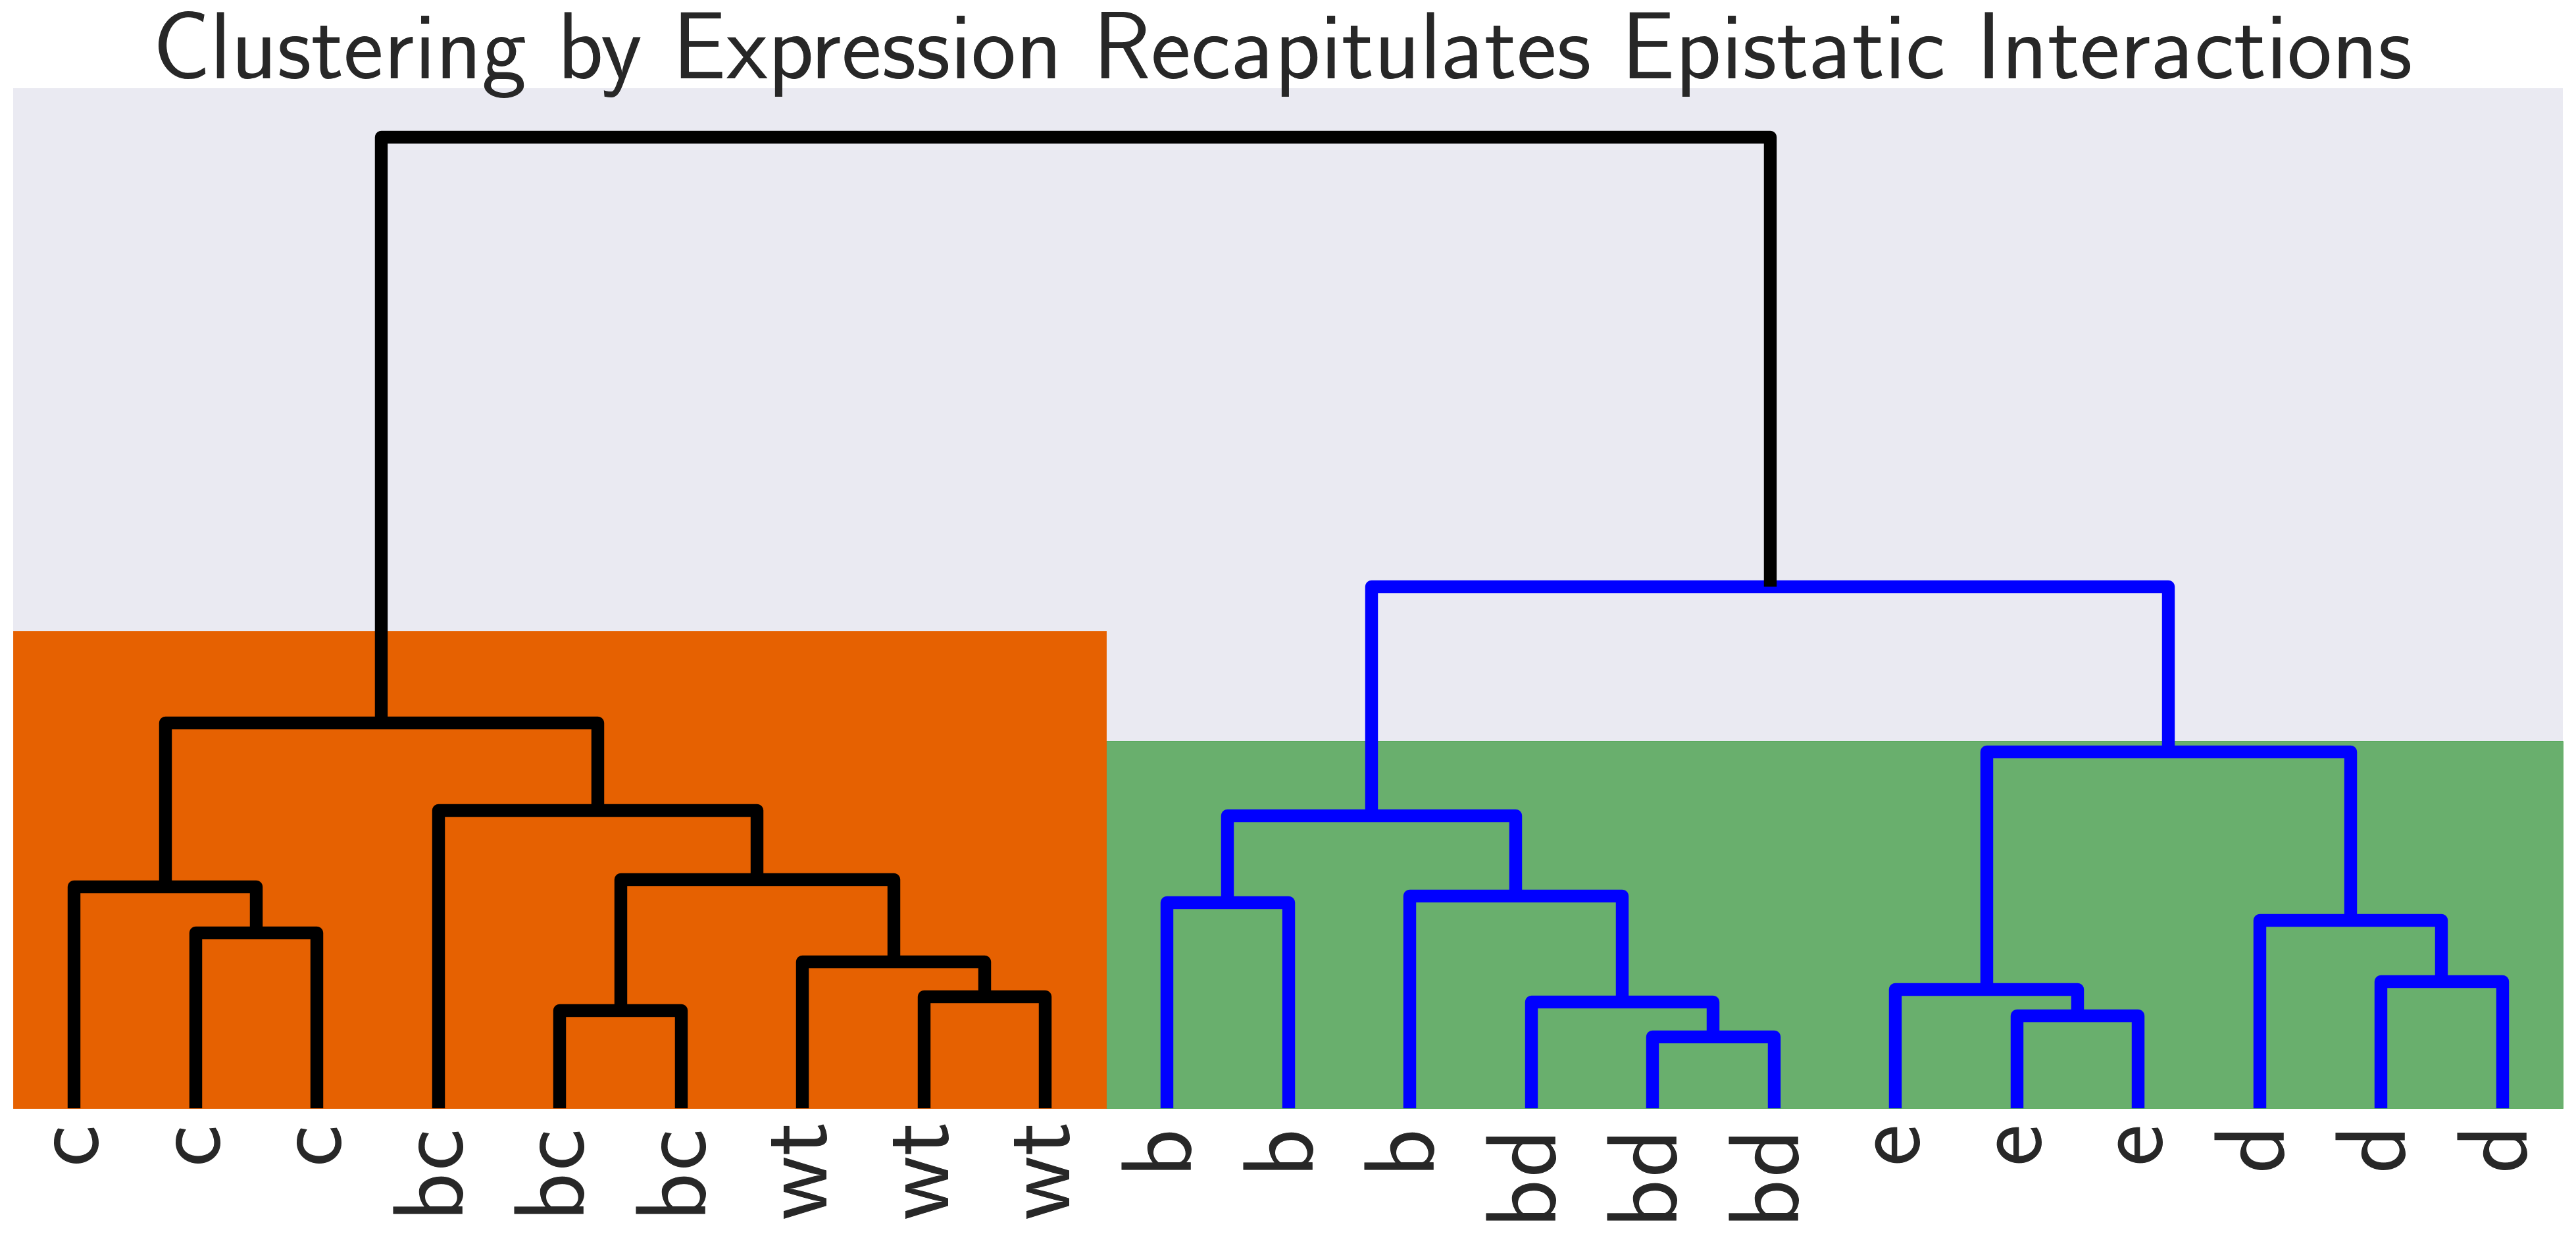

In [50]:
model = hierarchy.linkage(sklearn_pca.transform(pca_matrix), 'ward')
plt.figure(figsize=(25, 10))

labels = df_nD.genotypes.values

for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# ax, fig = plt.subplots()
plt.rcParams['lines.linewidth'] = 7

hierarchy.set_link_color_palette(['k', 'b'])
# fig, ax = plt.subplots()

hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    above_threshold_color='k'
)

ax = plt.gca()
height = ax.get_ylim()[1]*.36
ax.fill_between([90, 210], 0.0, height, 
                    where=[1,1], color='g', alpha=0.55, zorder=0)
ax.fill_between([0, 90], 0.0, height*1.3, 
                    where=[1,1], color='#e66101', alpha=1, zorder=0)

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Clustering by Expression Recapitulates Epistatic Interactions', fontsize=ft*1.5)
# plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

In fact, it does appear that *hif-1* is closest to the WT out of all the genes in this study. Moreover, please do notice that we can get epistasis relationships out of this data. Great!

## Filtering Does Not Seriously Alter Differentially Expressed Genes

In the section above, I filtered somewhat aggressively. Let's verify that there's not too much change in the number of genes that we detected.

In [48]:
q = 0.1
for key, df in thomas.beta.items():
    sig_genes = len(df[df.qval < q])
    mc = np.exp(df[df.qval < q].b.abs().max())
    print('{0} has {1} diff. exp. genes before filtering with mean fold change {2:.2g}'.format(key, sig_genes, mc))
    df = thomas.beta_filtered[key]
    sig_genes = len(df[df.qval < q])
    print('{0} has {1} diff. exp. genes after filtering'.format(key, sig_genes))
    print('-----------\n')


b has 1959 diff. exp. genes before filtering with mean fold change 7.7e+02
b has 1913 diff. exp. genes after filtering
-----------

d has 1039 diff. exp. genes before filtering with mean fold change 1.9e+03
d has 1025 diff. exp. genes after filtering
-----------

e has 2650 diff. exp. genes before filtering with mean fold change 6e+02
e has 2598 diff. exp. genes after filtering
-----------

a has 3330 diff. exp. genes before filtering with mean fold change 4e+02
a has 3301 diff. exp. genes after filtering
-----------

f has 381 diff. exp. genes before filtering with mean fold change 1.6e+03
f has 377 diff. exp. genes after filtering
-----------

c has 1026 diff. exp. genes before filtering with mean fold change 3.2e+02
c has 1020 diff. exp. genes after filtering
-----------



# Bayesian versus Spearman Regressions

Ok! Having verified that we still have plenty of power to identify these mutants, we need to go ahead and perform some statistics. Next, I will define some useful functions to make plotting easier. After that, I will begin a detailed analysis of the different prediction methods, specifically attempting to compare Spearman rank regression with a Bayesian linear regression of ranked data.

In [49]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)

    plt.ylabel(ylabel, fontsize=labelsize).set_path_effects([path_effects.Normal()])
    plt.xlabel(xlabel, fontsize=labelsize).set_path_effects([path_effects.Normal()])
    plt.title(title, fontsize=titlesize).set_path_effects([path_effects.Normal()])

    ax = plt.gca()
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])


## Spearman Regression Method

In order to perform the Spearman regression, this is what I will do:

 * Extract the pertinent datasets for the two genotypes I want to convert.
 * Find the genes that are altered between both conditions, regardless of direction
 * After finding this overlap, rank the genes by their $\beta$ coefficient in each dataset
 * Perform Least Squares on the ranked data, which is the Spearman Regression
 * Plot the results

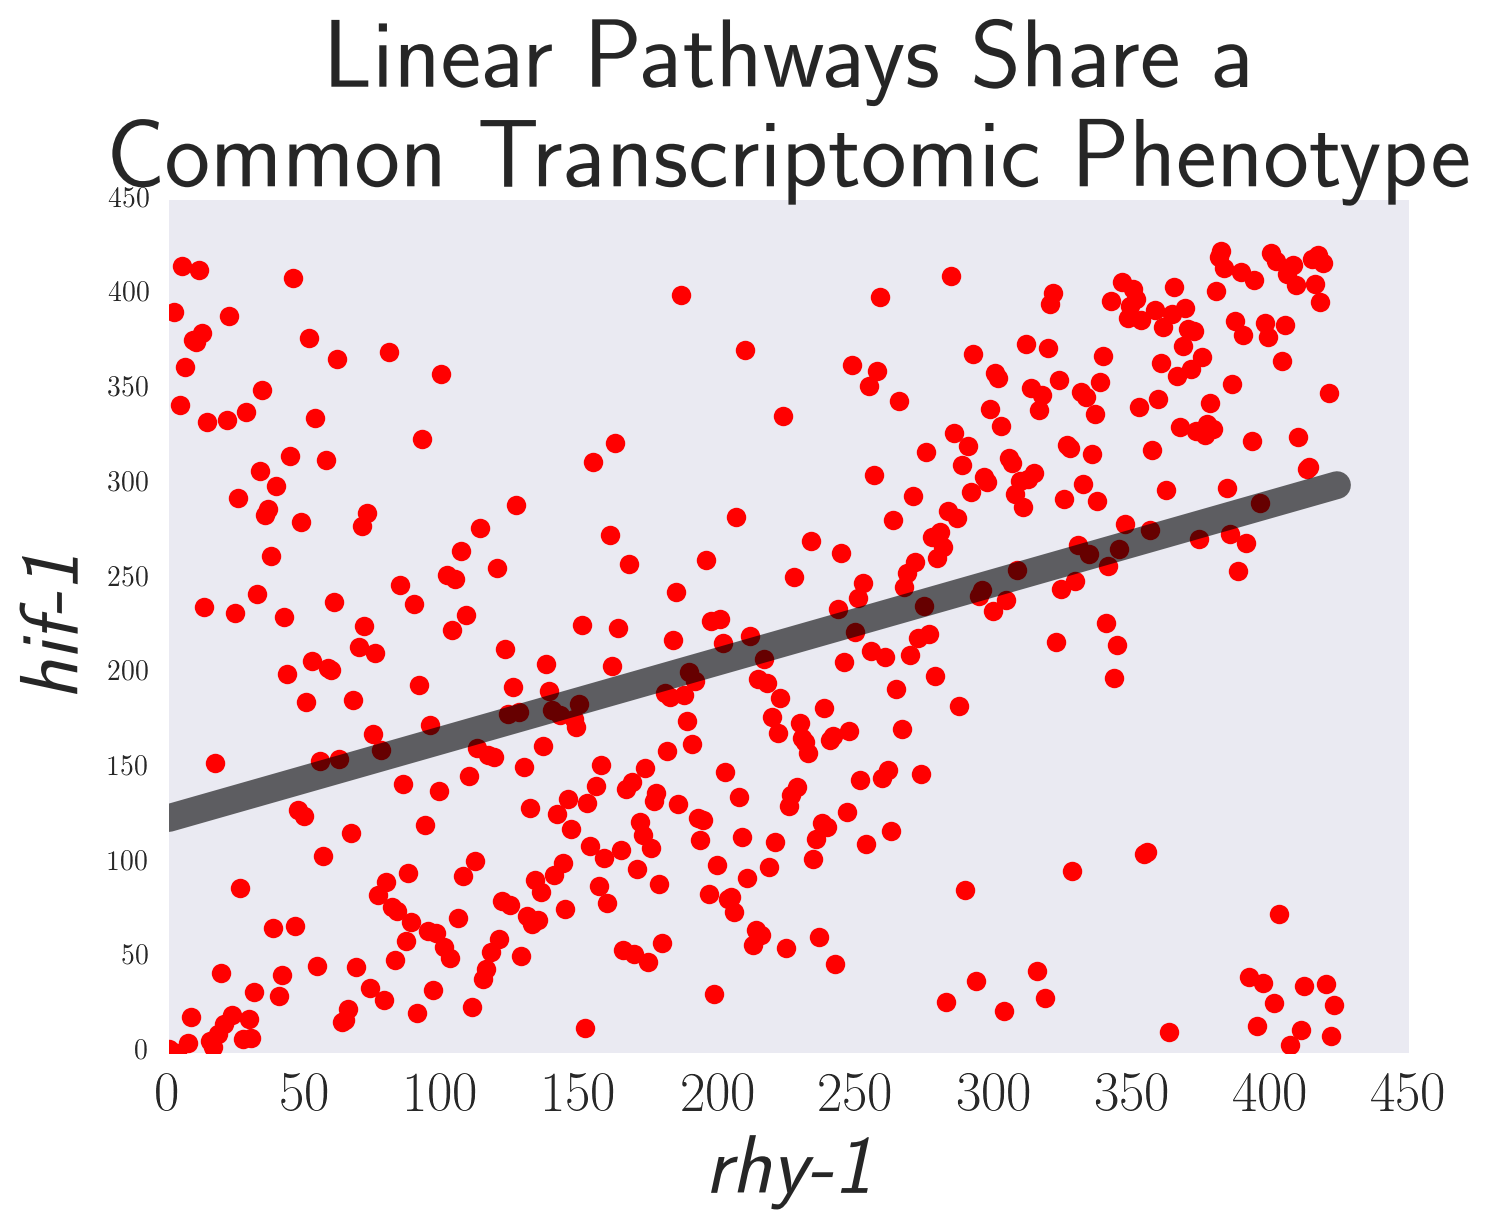

In [55]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# As an example, let me show you what a good spearman correlation looks like:
# name of the column that contains the isoform names:
genes = 'target_id'

# the genotypes to compare
letters = ['e', 'c']

# extract the dataframes from the morgan.hunt object
x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

# boolean logic to find the stat. sig. diff. genes that appear in both x and y
ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

# a function to rank order the data
def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

# apply said function
ovx = find_rank(ovx)
ovy = find_rank(ovy)

# calculate a linear regression on ranked data, which is equivalent to Spearman Ranked Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(ovx.r,ovy.r)

# We make two vectors in order to draw the best fit line on a plot
X = np.linspace(0, len(ovx.r))
Y = slope*X + intercept

# Plot the genes that are statistically significantly altered in both X and Y
plt.plot(ovx.r, ovy.r, 'ro', alpha=1, label='Overlapped Diff. Exp. Genes')

# Plot the best fit line
plt.plot(X, Y, 'k-', alpha=0.6, lw=10, label= 'Best Fit')

plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype', fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(genotype_mapping[letters[0]], fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(genotype_mapping[letters[1]], fontsize=30).set_path_effects([path_effects.Normal()])
plt.xticks(fontsize=20)
plt.savefig('../output/spearmanr_b_and_c.pdf')

Spearman R predicts a trend, but the best fit we found doesn't agree with the one I would predict with my eye. We can probably do better if we use a Bayesian regression that minimizes least squares but using a Student-T Prior, NOT a Gaussian. 

## Bayesian Robust Regression
In order to perform the Spearman regression, this is what I will do:

 * Extract the pertinent datasets for the two genotypes I want to convert.
 * Find the genes that are altered between both conditions, regardless of direction
 * After finding this overlap, rank the genes by their $\beta$ coefficient in each dataset
 * Perform Least Squares on the ranked data, but use a Student-T instead of a Gaussian prior.
   * The regression in this case is sampled using a full Monte Carlo Simulation.
 * Identify outliers to this regression, and run a second regression on outliers to see if there are complex regulatory relationships between these genes.
 * Plot the results
 
In other words, given ranked data, I will find the line that is likeliest to explain the data by finding:
\begin{equation}
P(D | \mu, \sigma) \propto \prod_i \mathrm{StudentT}(D_i(x) - \mu(x), \sigma)
\end{equation}

The Student-T distribution has considerably heavier tails than a Gaussian distribution, so it will not consider the evidence provided by outliers as informative as a Gaussian would. 

In order to perform this simulation, we will use the **pymc3** package to specify the model. This model was inspired and successfully deployed thanks to Thomas Wiecki; specifically thanks to [this blog entry](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/) by him. Thanks Tom!

## Figure 4. Complex Regulation Generates Detectable Patterns in Transcriptomes

The code that we will run below was used to generate the bottom panel of figure 4 in our paper. The figure as is output here was only subjected to very minor aesthetic modifications post-generation (such as moving the title a little above where it appears here). 

In [56]:
def robust_regress(data):
    """A robust regression using a StudentT distribution instead of a Gaussian model."""
    with pm.Model() as model_robust:
        family = pm.glm.families.StudentT()
        pm.glm.glm('y ~ x', data, family=family)
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 sec

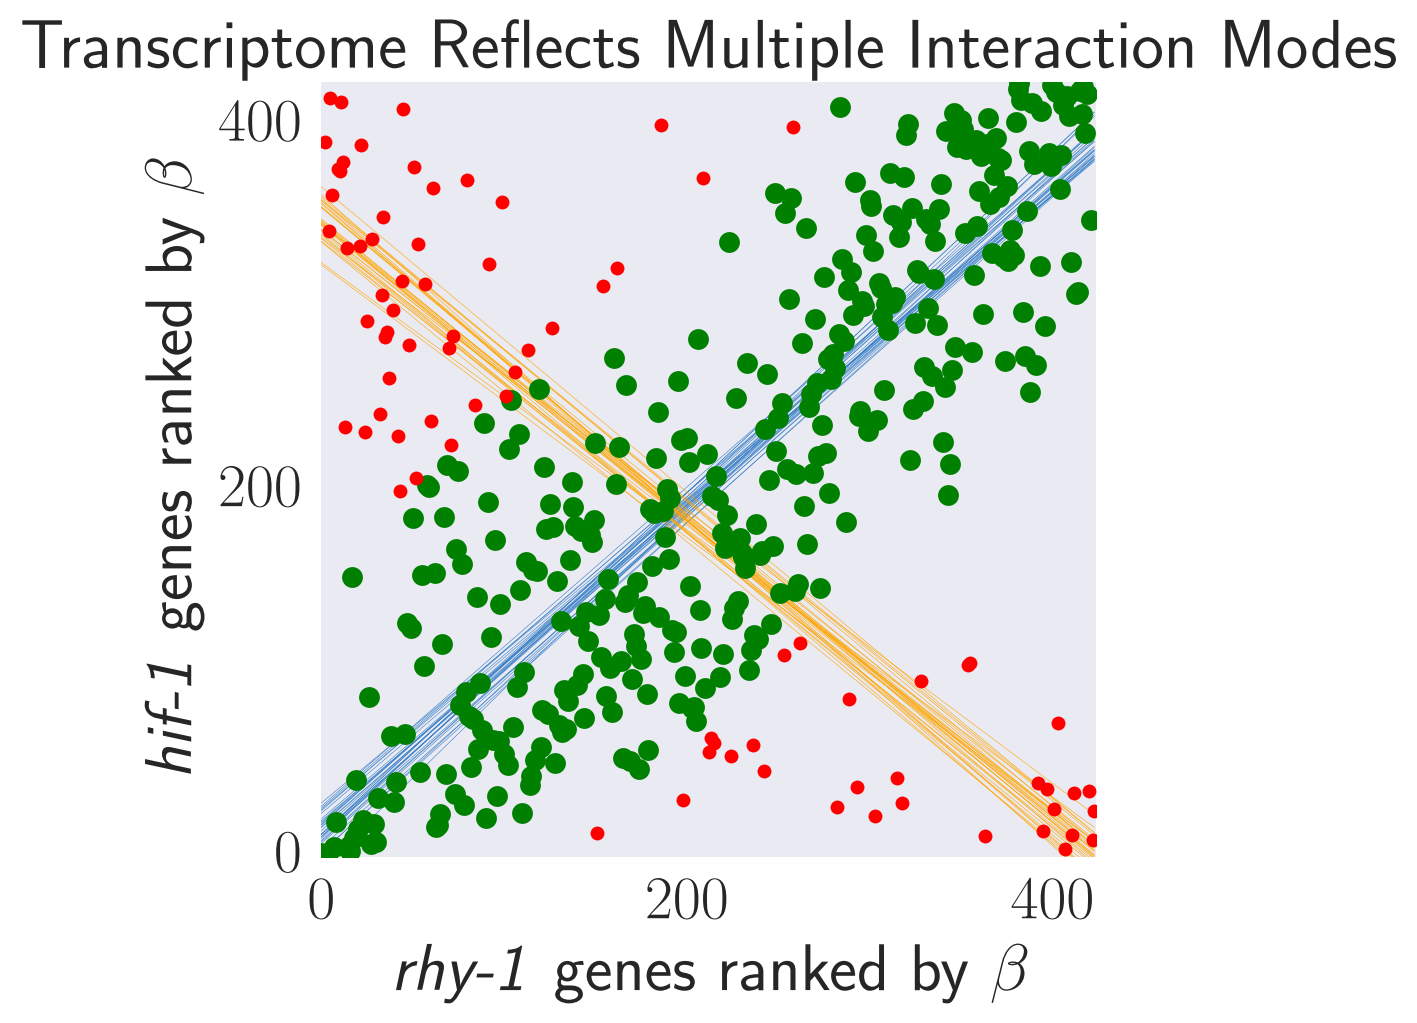

In [59]:
# Set up MCMC parameters
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')

plt.plot(ovx.r, yri, 'go', ms = 7.5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, 200, 400], fontsize=22)
plt.xticks([0, 200, 400], fontsize=22)
pathify('Transcriptome Reflects Multiple Interaction Modes', r'\emph{rhy-1} genes ranked by $\beta$', 
        r'\emph{hif-1} genes ranked by $\beta$', labelsize=24)
plt.savefig('../output/multiple_modes_{0}.pdf'.format(letters[0]+letters[1]))
# plt.legend()


There, much better! Penalizing outliers allows us to estimate the primary regression slope really well (blue lines). Here, each blue line is the result of a simulation, and we can see that they are all clustered together. Having estimated the first regression, we can proceed to identify outliers. 

Now, there are multiple ways to identify outliers, and this is the point where I am going to cheat just a little bit. If we pretend that the model is gaussian (it isn't), then we can identify outliers (fairly aggressively) via the following method. If

\begin{equation}
z(i) = \frac{D_i(x) - \mu(x)}{\sigma_\mu + \sigma_{\mathrm{Intercept}} + \sigma_\mathrm{Data}} > 1
\end{equation}

then $z(i)$ is an outlier. 

After identifying these outliers, I can then pool them and run a second regression on them (orange lines). These lines are also quite clustered, and the slope is practically 1! Wow!


## Figure 2. Positive Regulatory Relationships Can Be Identified By Transcriptomic Correlation

In the above example, we saw that *rhy-1* and *hif-1* share a complex regulatory relationship as exhibited by the cross-pattern. However, an important point is whether or not this cross pattern appears in all datasets. While we cannot generalize yet (this kind of analysis is very new) we should definitely make sure that not all of our genes are exhibiting this cross pattern. Below, I show some a pair of genes that don't exhibit a cross pattern.

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.0 sec

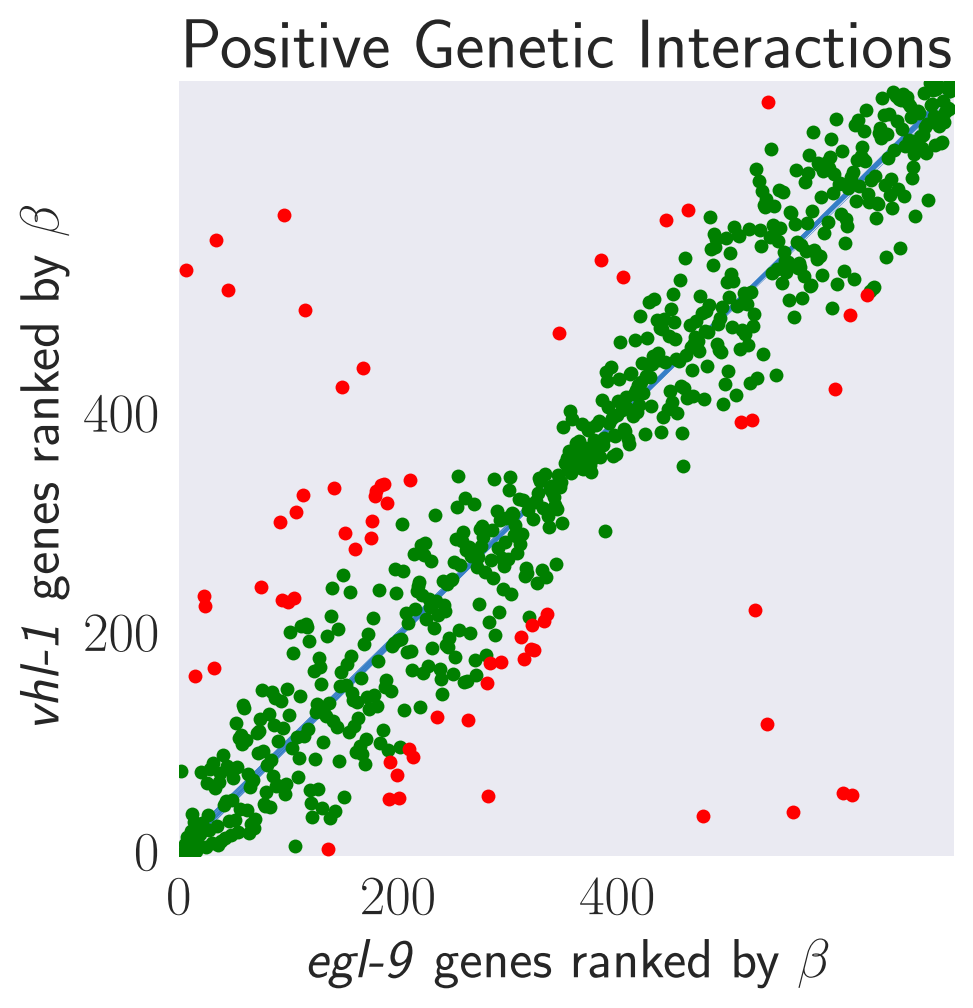

In [60]:
genes = 'target_id'

letters = ['b', 'd']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

# Set up MCMC parameters
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

# data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
# trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
# pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
#                                  label='posterior predictive regression lines',
#                                  color='#FFA500')

plt.plot(ovx.r, yri, 'go', ms = 5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, 200, 400], fontsize=20)
plt.xticks([0, 200, 400], fontsize=20)
pathify('Positive Genetic Interactions', r'\emph{egl-9} genes ranked by $\beta$', 
        r'\emph{vhl-1} genes ranked by $\beta$')
plt.savefig('../output/positive interaction{0}.pdf'.format(letters[0]+letters[1]))
# plt.legend()

# if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
#     t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
#     t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
#     if t1 == -t2:
#         print('Complex Regulation at Work')

# Pairwise Analysis of All Genes Using Spearman Correlation

Given what we found above, we know that the spearman analysis is good to use to get a rough fast idea of how our data looks. Let's go ahead and run the analysis for all pairwise comparisons that can be made using this dataset. 

Spearman correlations and hypergeometric tests can be performed using the class morgan.brenner. 

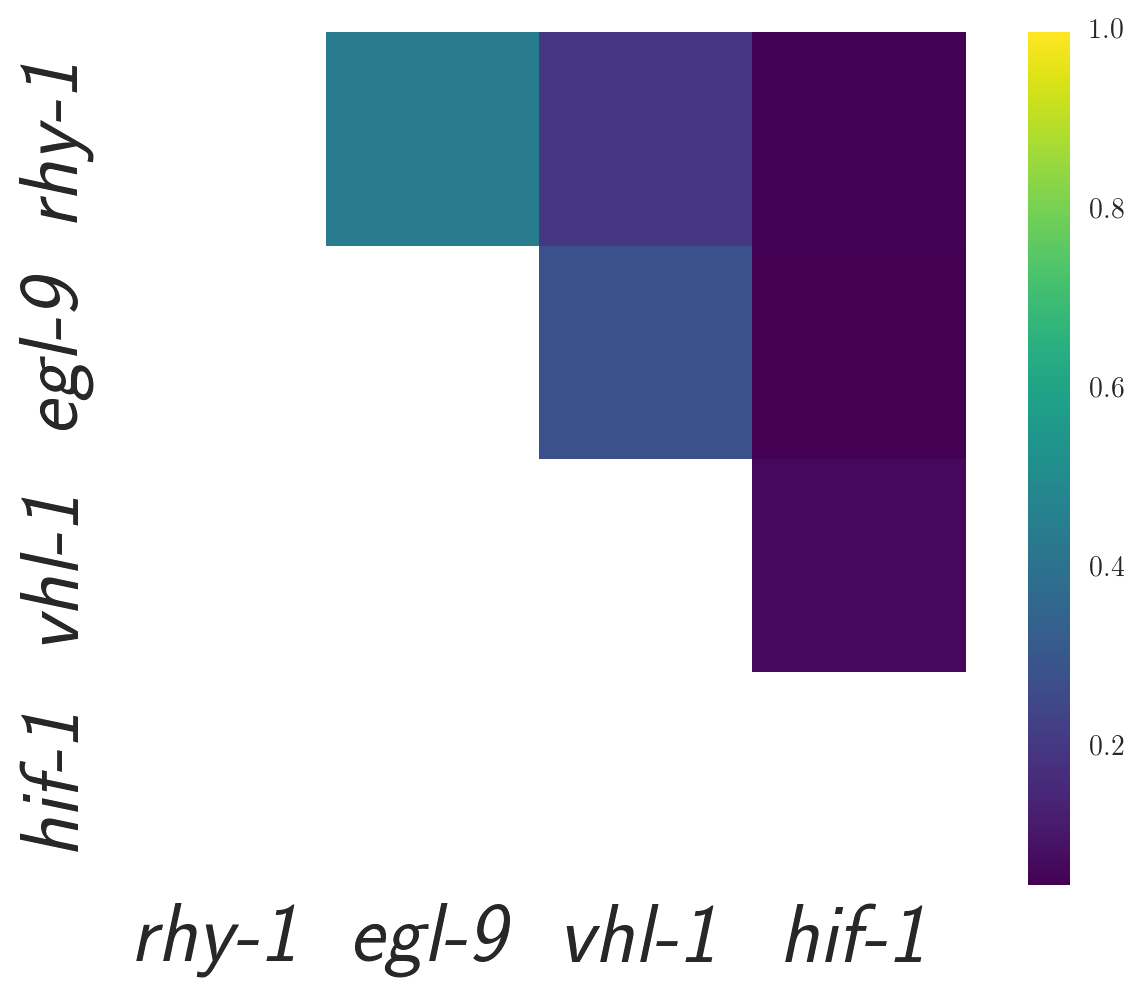

In [62]:
# Define a 'genes' variable that will be used for labelling every plot from here on out:
genes = [genotype_mapping[x] for x in thomas.single_mutants]

# Perform Correlation Analysis
def tri_plot(matrix, xlabels, ylabels=[]):
    vmin= matrix.min().min()
    vmax= np.max(matrix).max()

    if len(ylabels) == 0:
        ylabels = xlabels
        
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True, vmin=vmin, vmax=vmax)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)


sydney = morgan.brenner('spearman', thomas)
tri_plot(sydney.rho.as_matrix(columns=thomas.single_mutants), genes)
# plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)
# plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

From the above, we can draw the following arrows:


Interaction | $\rho$ |
----------- | ------- |
b -gp- d| 0.92
b -gp- e| 0.96
d -gp- e| 0.81
d -g- c| 0.53
b -g- c| 0.38
e -g- c| 0.41

Due to the weakness of the spearman correlation of b, d, e with c, we can't draw any conclusions about its sign


# Hypergeometric Analysis:

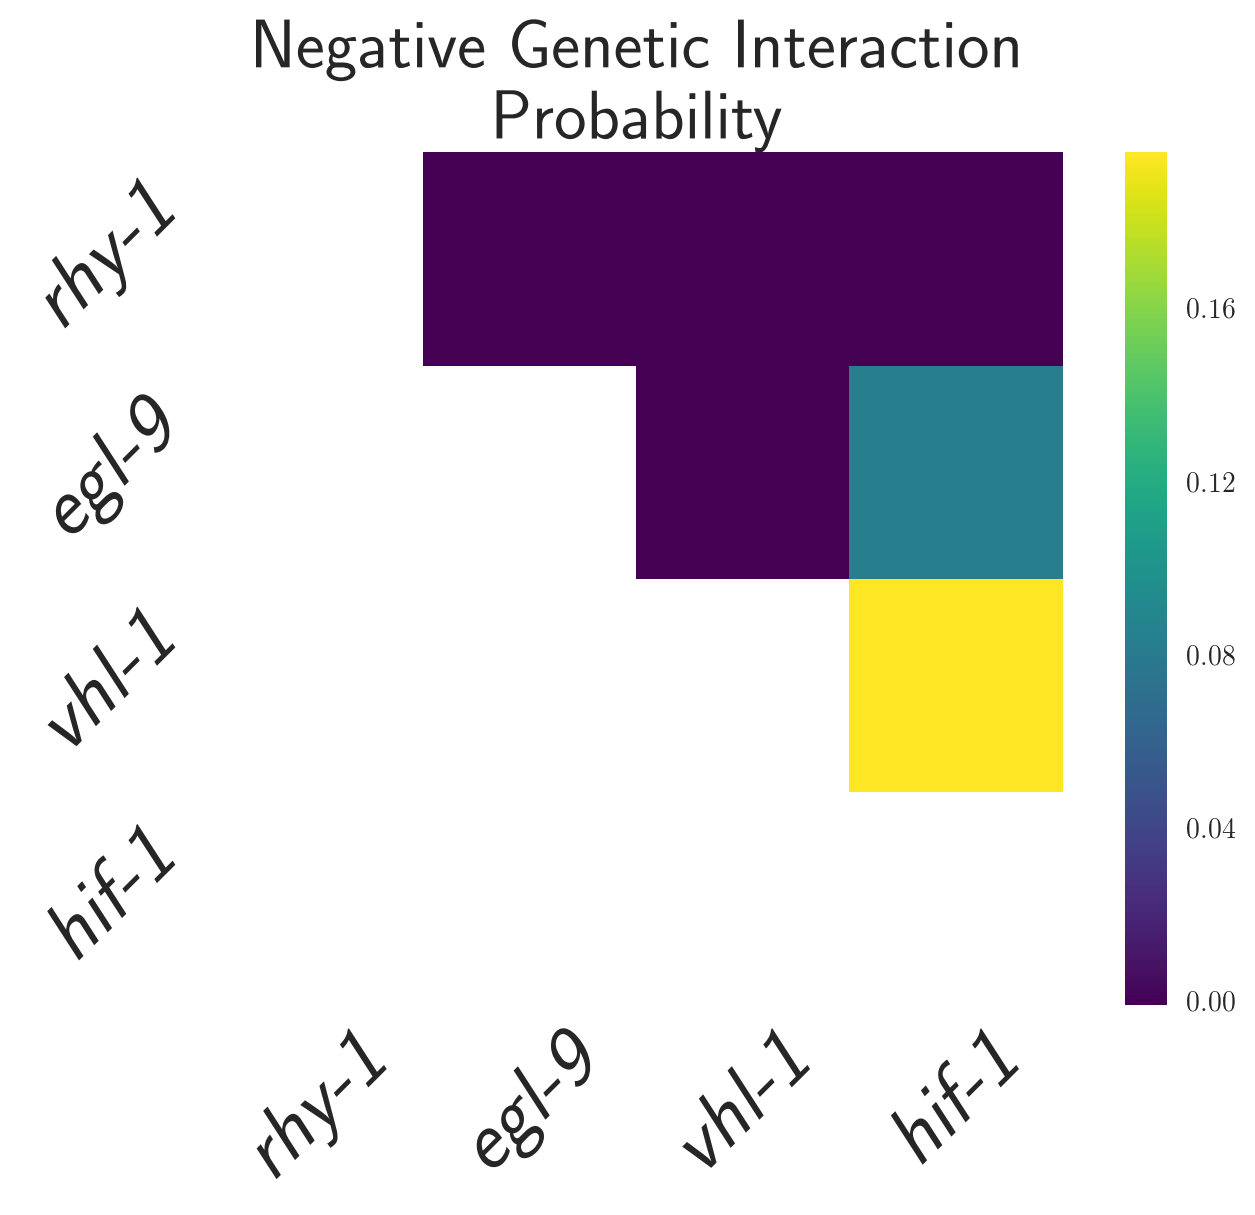

In [65]:
mat = sydney.hyper_minus.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]
tri_plot(mat, genes)
pathify('Negative Genetic Interaction\nProbability', '', '')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('../output/probability_of_inhibition_single_mutants.pdf', bbox_inches='tight')

# thomas.prob_minus[thomas.prob_minus > 10**-4]

# Analysis Using Robust Spearman Regression

What I do here is try to identify trends. Namely, for two genotypes X and Y, I fit a line using a Bayesian robust regression (see methods) thru the rank-ordered regression coefficients that are statistically significantly different from 0 and that are present in both X and Y. Next, I use this Bayesian framework to identify any and all outliers to the regression. 

In order to test for alternative modes of interaction in this dataset, I take the outliers and I run the same regression again *on the outliers*. If this second interaction has an opposite sign to the first, then we predict that there are two modes of interaction, subject to the following caveats:

 * Both the primary and secondary regressions yield large slopes values (>0.7)
 * The first regression results in many outliers (at least 10% of all the values)

Finally, because of the approach I used, I can also predict which genes are under what mode of regulation. Super cool!

In [910]:
barbara = morgan.mcclintock('bayesian', thomas, True)


starting comparison of c, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
starting comparison of c, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of c, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of c, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
starting comparison of e, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of e, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

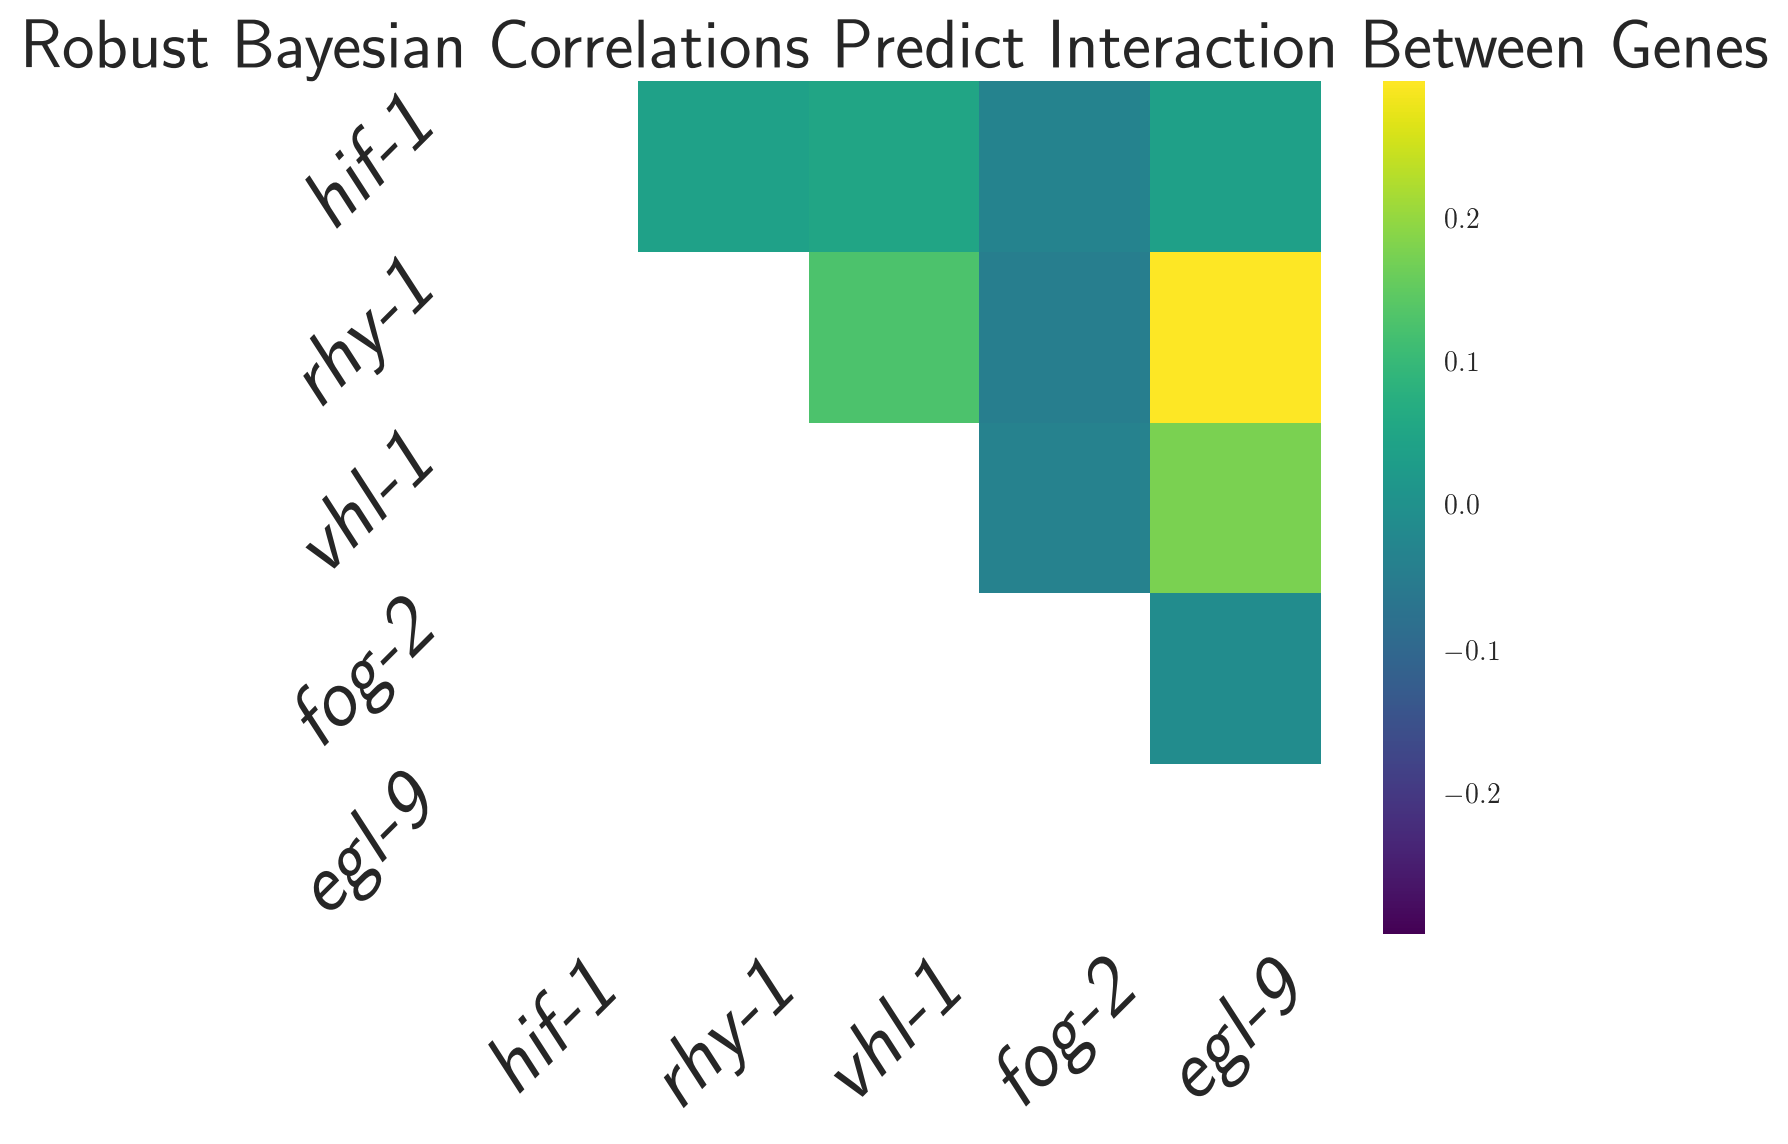

In [911]:
mat = barbara.robust_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
pathify('Robust Bayesian Correlations Predict Interaction Between Genes', '', '')
plt.savefig('../output/bayes_primary_single_mutants.pdf', bbox_inches='tight')

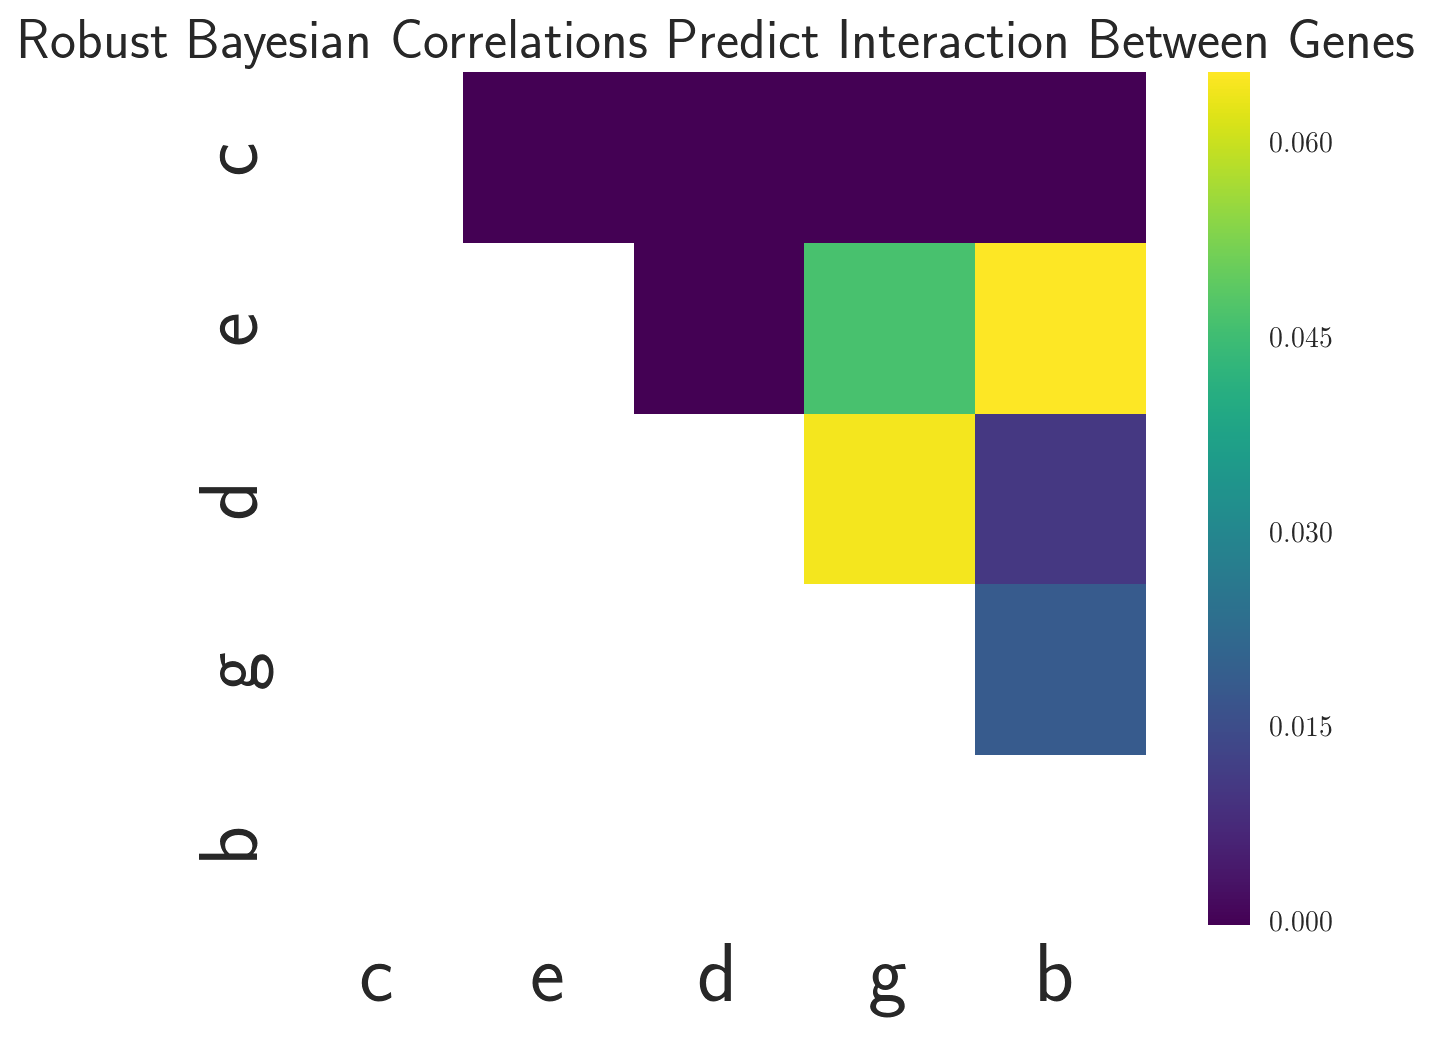

In [912]:
mat = barbara.secondary_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, thomas.single_mutants)
plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)


Another way to plot the results from the regression above is to make scatterplots. For that, it's best to work with tidy dataframes. 

In [913]:
def tidy_df(df, corr='corr'):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - please specify whether this dataframe is from morgan.robust_regression (write 'corr')
    or from morgan.robust_regression_secondary() (write 'outlier')
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable', 'fraction' and 'pair'
    """
    df = df.copy()
    df['corr_with'] = thomas.single_mutants
    df = pd.melt(df, id_vars='corr_with')
    df = df[df.corr_with != df.variable]

    def add_fraction_outliers(x, fraction='corr'):
        if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
            dd = barbara.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan

    df['fraction_outliers'] = df.apply(add_fraction_outliers, args=(corr,), axis=1)
    df['pair'] =  df.variable + df.corr_with
    return df

d_pos = tidy_df(barbara.robust_slope)
d_pos['regression'] = 'primary'
d_minus = tidy_df(barbara.secondary_slope, corr='outliers')
d_minus['regression'] = 'secondary'

In [914]:
frames = [d_pos, d_minus]
d = pd.concat(frames)

def different(x):
    p = x.pair
    primary = d[(d.pair == p) & (d.regression == 'primary')].value.values[0]
    secondary = d[(d.pair == p) & (d.regression == 'secondary')].value.values[0]
    
    if primary == 0 or secondary == 0:
        return 0
    elif (primary*secondary > 0):
        return -1
    else:
        return 1

d['different'] = d.apply(different, axis=1)

In [916]:
d.dropna(subset=['fraction_outliers'], inplace=True)

In [918]:
def special_add(x):
    if x.regression == 'secondary':
        if x.different == -1:
            return np.nan
        else:
            return x.value
    if d[(d.regression=='secondary') & (d.pair == x.pair)].different.values == -1:
        to_add = d[(d.regression=='secondary') & (d.pair == x.pair)].value.values[0]
        return x.value + to_add
    else:
        return x.value

d['corrected'] = d.apply(special_add, axis=1)

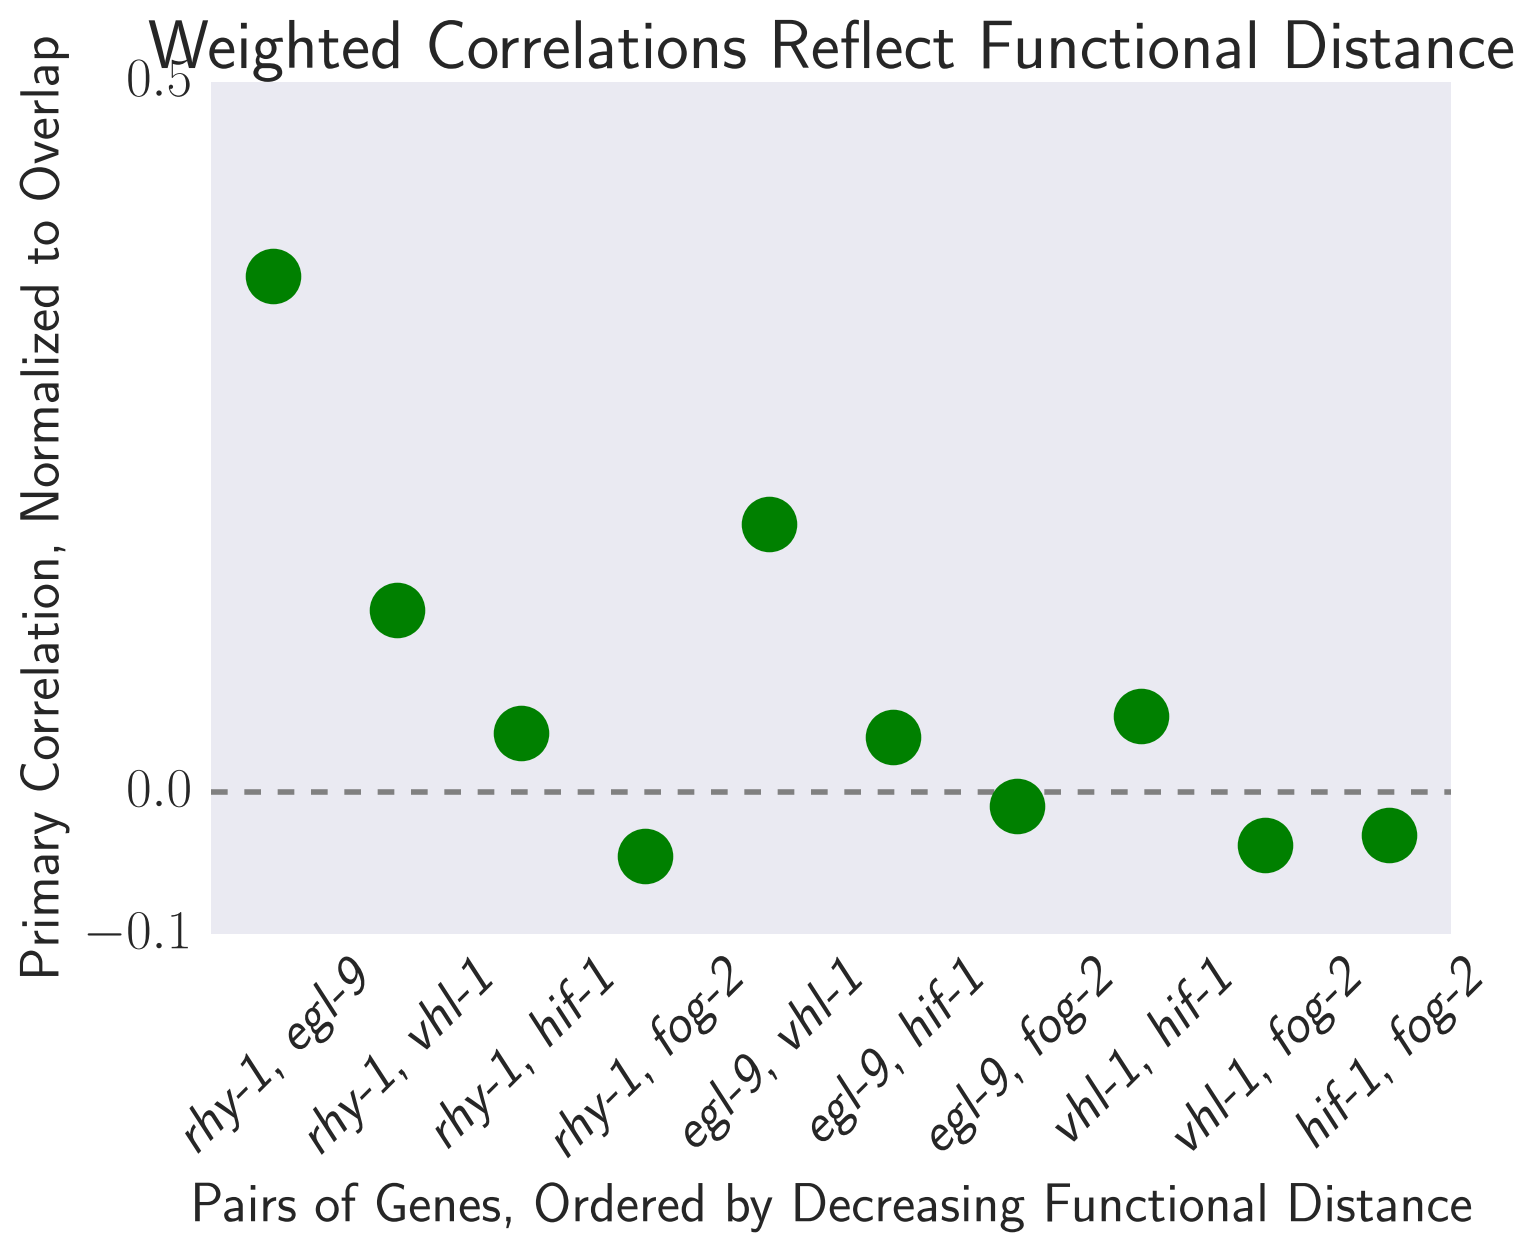

In [919]:
def sorted_pairs(x):
    key = x.pair
    if key in sort_pairs.keys():
        return sort_pairs[key]
    else:
        return np.nan
d.dropna(subset=['corrected'], inplace=True)
d['sort_pairs'] = d.pair.map(sort_pairs)
# d.head()
d.sort('sort_pairs', inplace=True)
d['genes'] = d.pair.map(decode_pairs)
sns.stripplot(x='genes', y='corrected', data=d[d.regression=='primary'], size=20, color='g')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.5], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
pathify('Weighted Correlations Reflect Functional Distance',
        'Pairs of Genes, Ordered by Decreasing Functional Distance',
       'Primary Correlation, Normalized to Overlap')
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

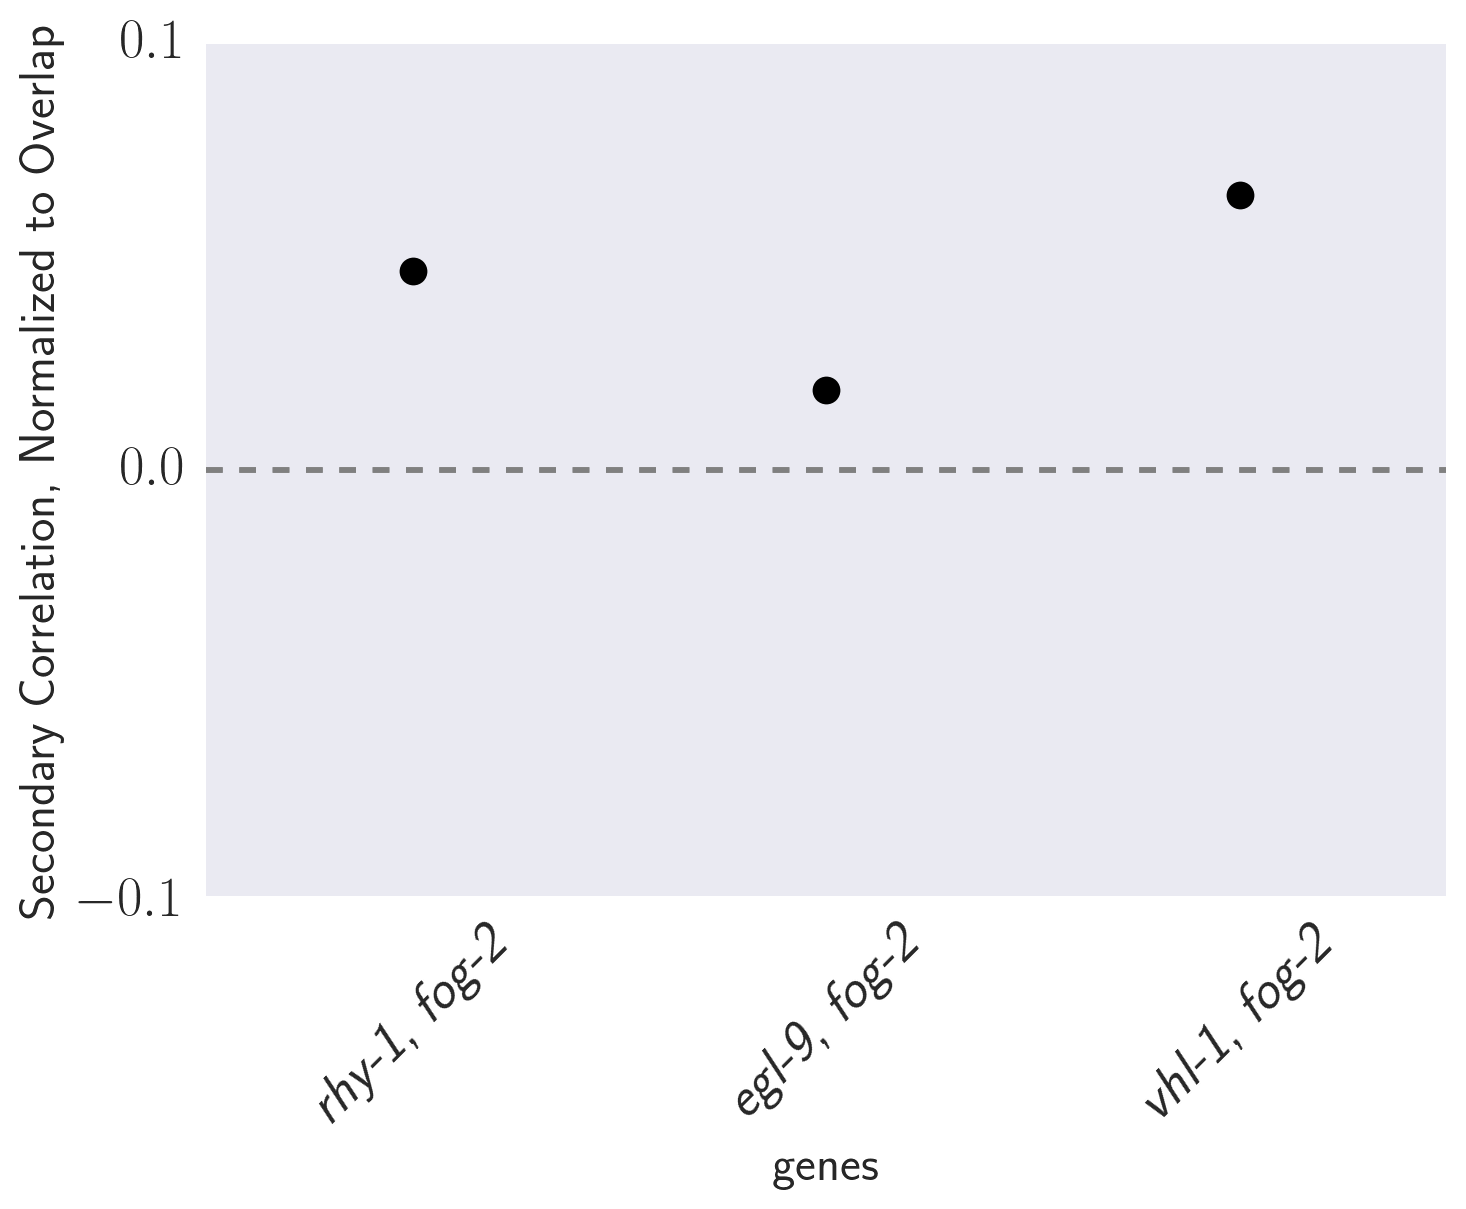

In [920]:
sns.stripplot(x='genes', y='corrected', data=d[(d.regression=='secondary') & (d.different == 1)], size=10, color='k')
plt.axhline(0, ls='--', color='0.5')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.ylabel('Secondary Correlation, Normalized to Overlap')

It appears that 'C' and 'B' and 'C' and 'E' interact in both a positive and negative manner and both correlations are well supported by evidence. Intriguing!

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!

A first approach is to inspect the double mutants by Spearman correlation analysis to the single mutants that make them up. A quick visualization will show us any epistasis and the extent of it:

In [921]:
alfred = morgan.sturtevant('epistasis analysis')
alfred.epistasis_analysis(thomas)
alfred.epistasis_secondary(thomas, True)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in

([<matplotlib.axis.YTick at 0x266b450b8>,
 <a list of 3 Text yticklabel objects>)

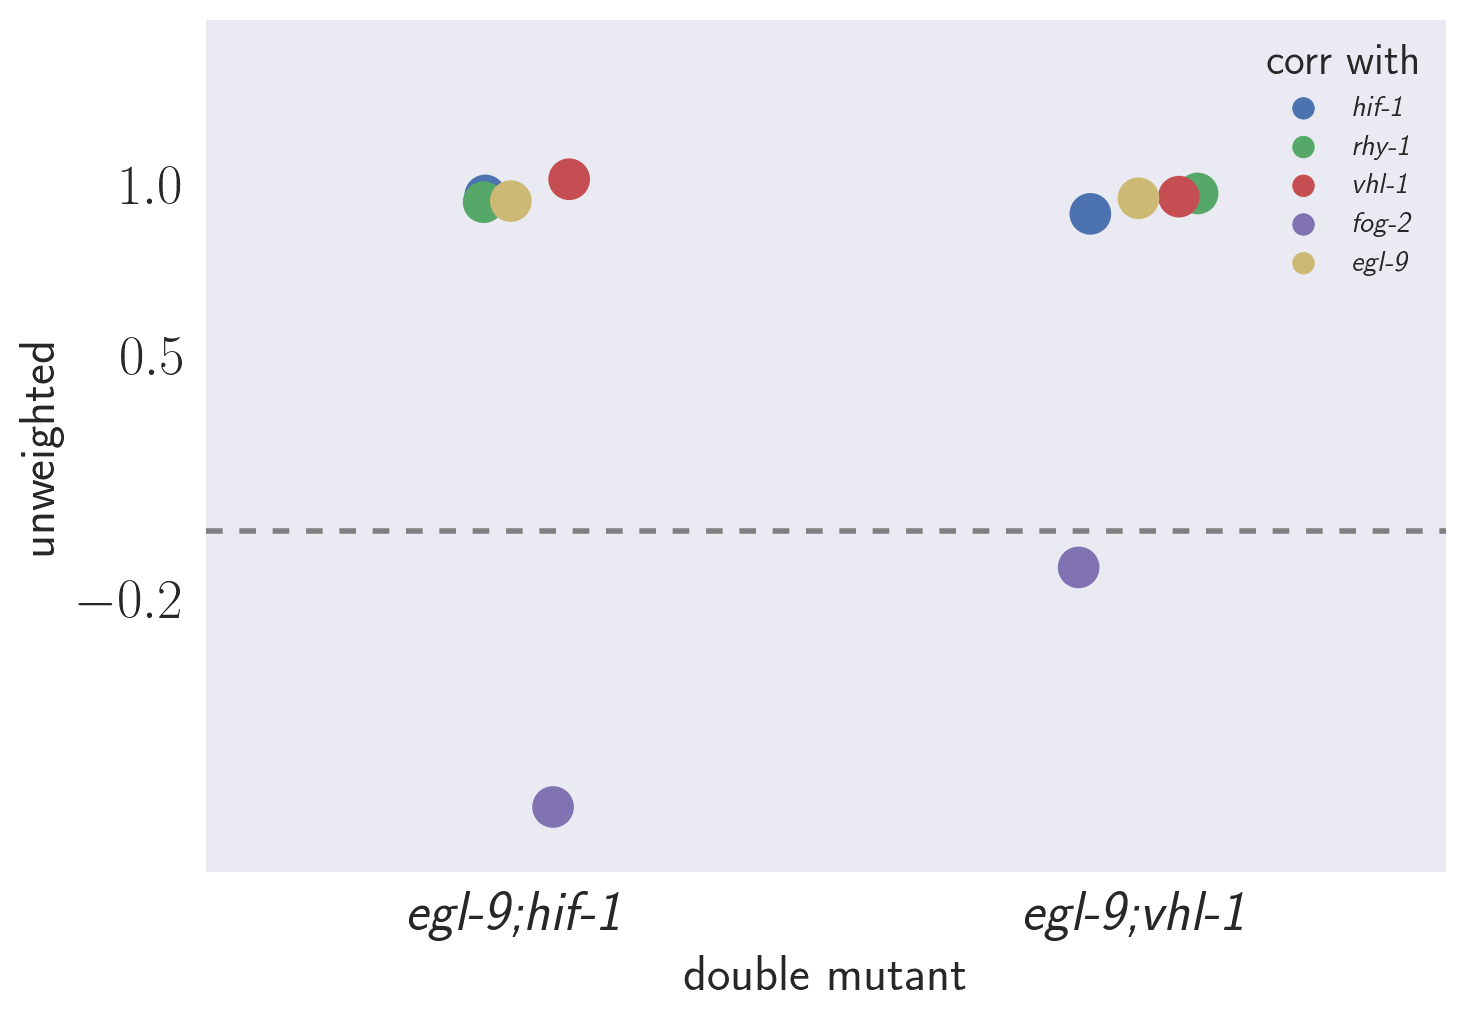

In [922]:
alfred.epistasis['unweighted'] = alfred.epistasis.correlation/alfred.epistasis.weights


alfred.epistasis['double mutant'] = alfred.epistasis.double_mutant.map(genotype_mapping)
alfred.epistasis['corr with'] = alfred.epistasis.corr_with.map(genotype_mapping)

sns.stripplot(x='double mutant', y='unweighted', hue='corr with', data=alfred.epistasis, size=15, jitter=True)
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.2, 0.5, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x266b451d0>,
 <a list of 3 Text yticklabel objects>)

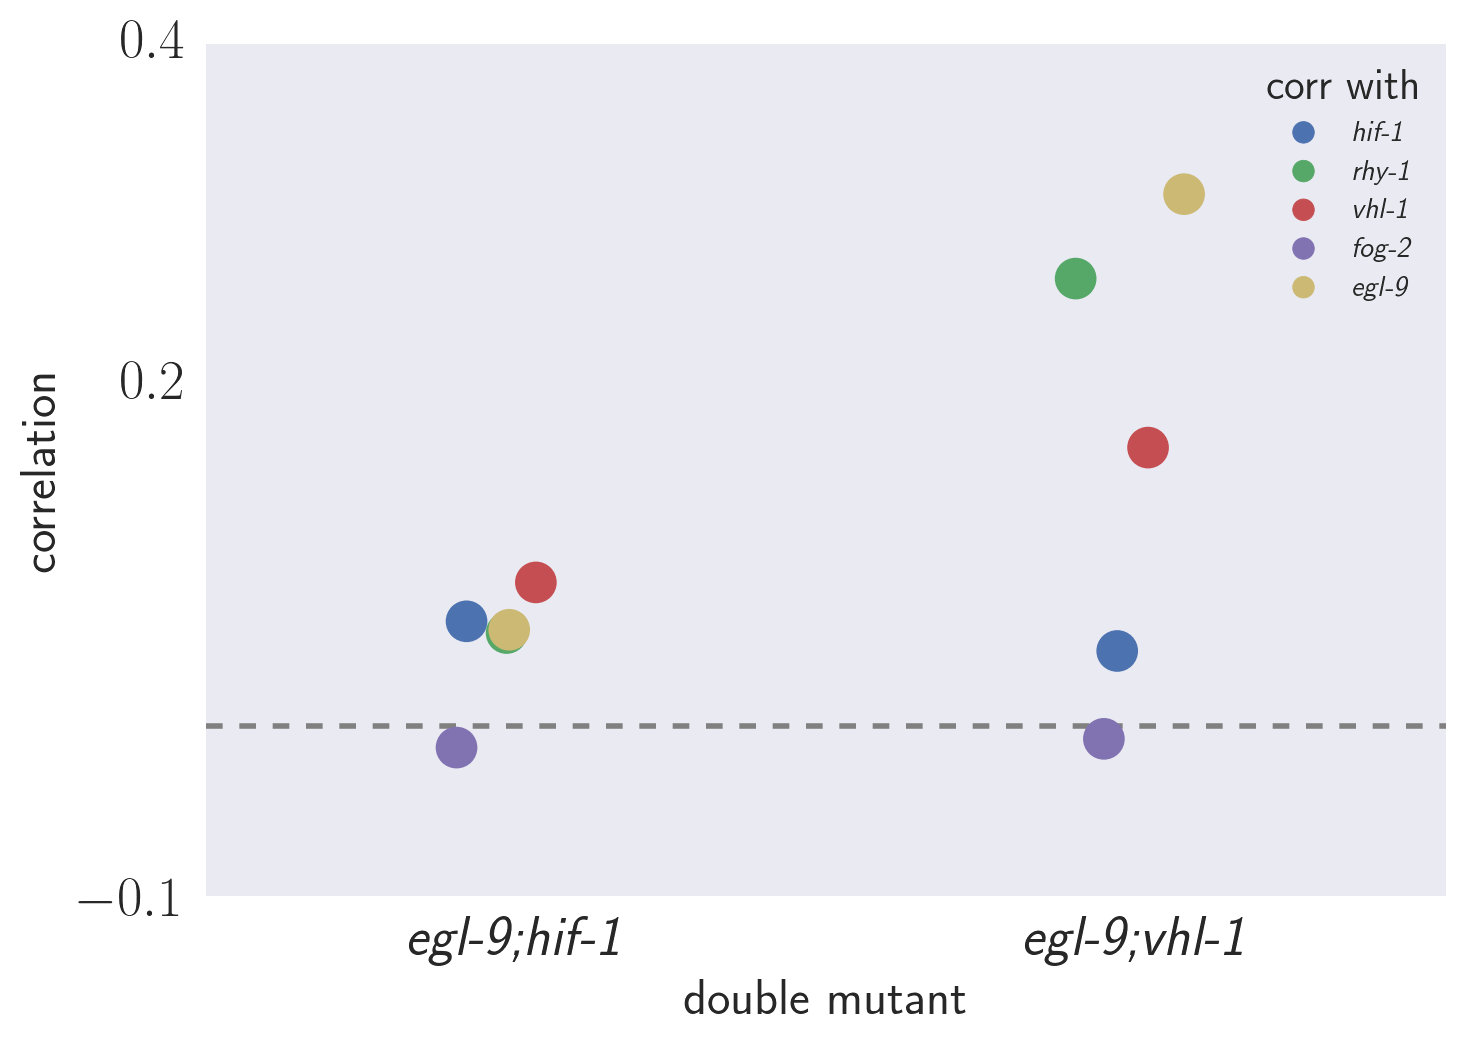

In [923]:
sns.stripplot(x='double mutant', y='correlation', hue='corr with', data=alfred.epistasis, size=15, jitter=True)
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.1, 0.2, 0.4], fontsize=20)

([<matplotlib.axis.YTick at 0x292cb0860>,
 <a list of 3 Text yticklabel objects>)

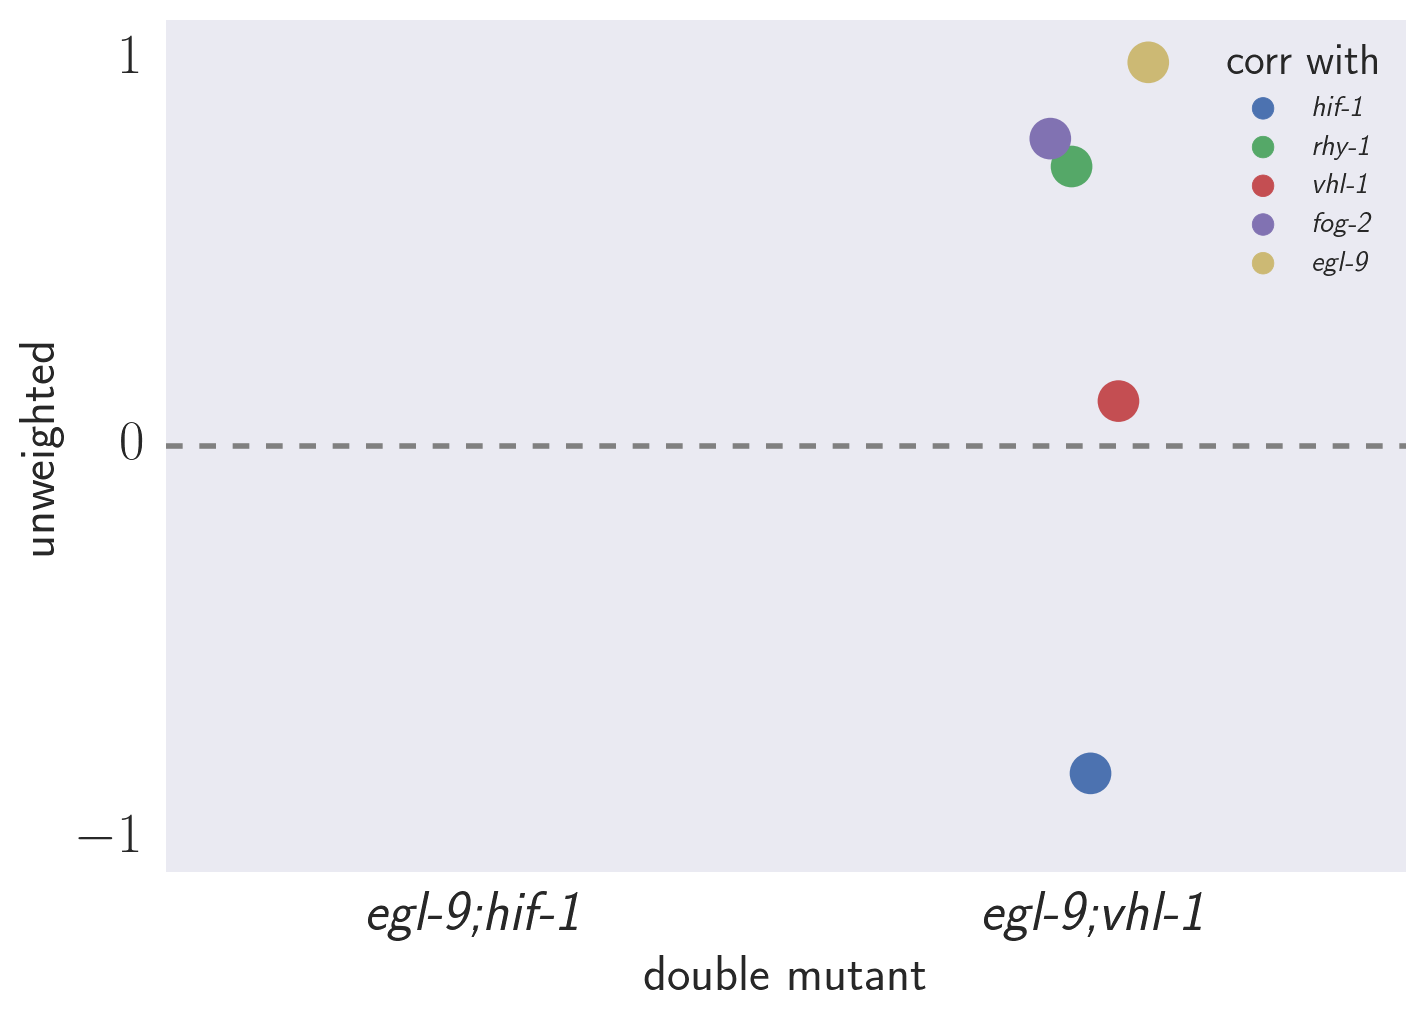

In [924]:
alfred.epistasis_secondary['unweighted'] = alfred.epistasis_secondary.correlation/alfred.epistasis_secondary.weights
alfred.epistasis_secondary['fractional corr'] = alfred.epistasis_secondary.correlation/alfred.epistasis.correlation.abs()

alfred.epistasis_secondary['double mutant'] = alfred.epistasis_secondary.double_mutant.map(genotype_mapping)
alfred.epistasis_secondary['corr with'] = alfred.epistasis_secondary.corr_with.map(genotype_mapping)


sns.stripplot(x='double mutant', y='unweighted', hue='corr with', data=alfred.epistasis_secondary,
              size=15, jitter=True)
plt.xticks(fontsize=20)
plt.ylim(-1.1, 1.1)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-1, 0, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x292ca7ef0>,
 <a list of 3 Text yticklabel objects>)

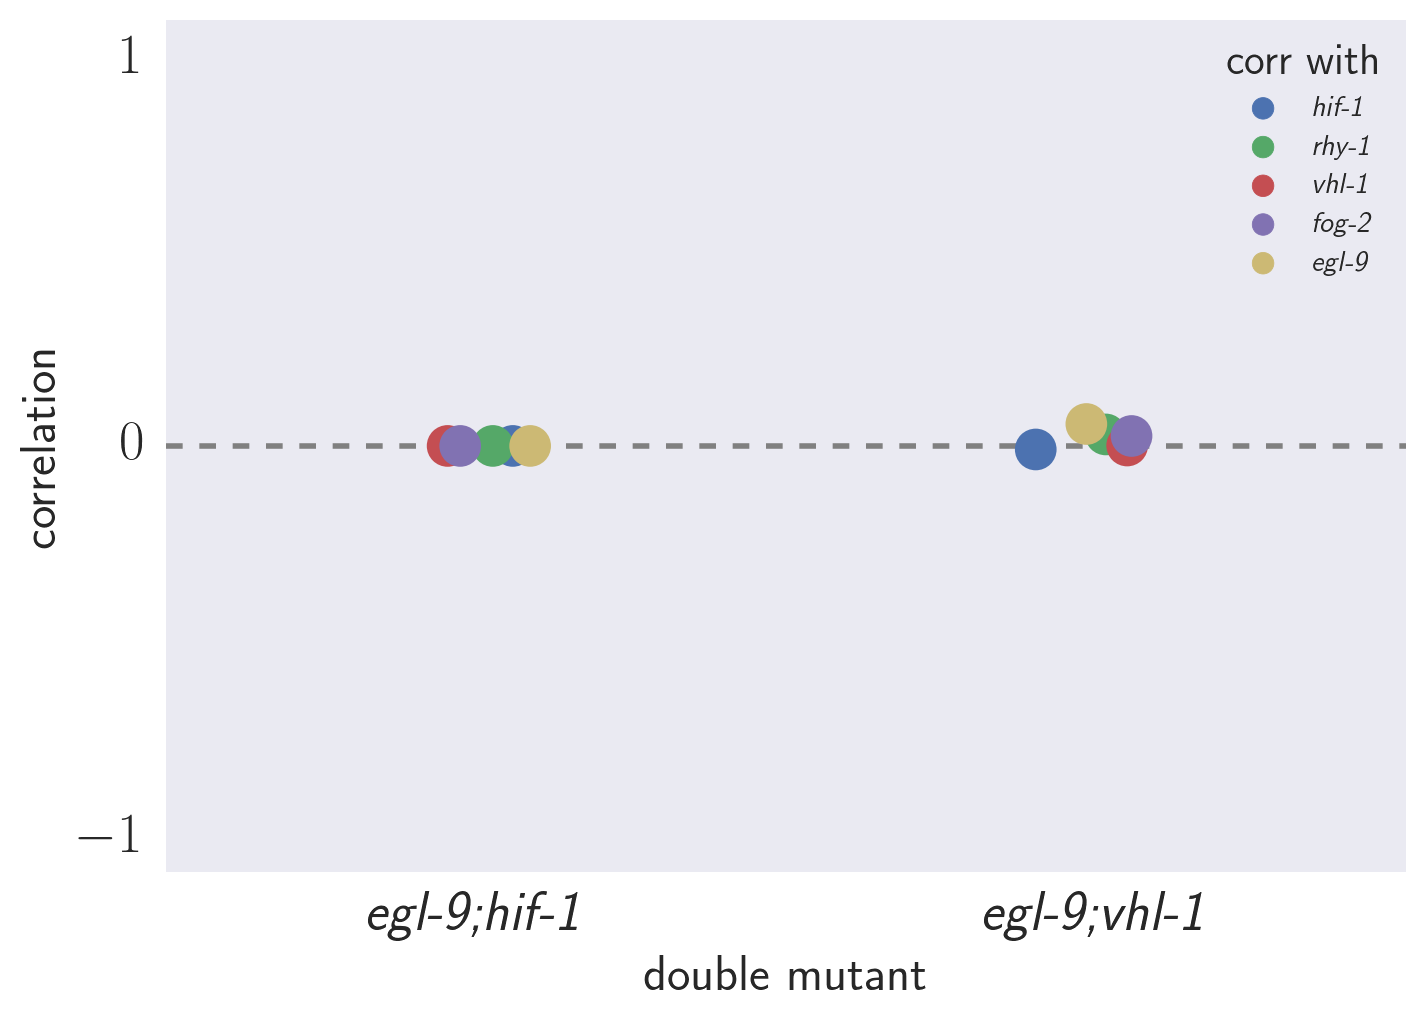

In [925]:
sns.stripplot(x='double mutant', y='correlation', hue='corr with', data=alfred.epistasis_secondary,
              size=15, jitter=True)
plt.xticks(fontsize=20)
plt.ylim(-1.1, 1.1)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-1, 0, 1], fontsize=20)

('c', 'b') 60
15 15
b                             WLS Regression Results                            
Dep. Variable:                      b   R-squared:                       0.314
Model:                            WLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     6.394
Date:                Mon, 19 Sep 2016   Prob (F-statistic):             0.0241
Time:                        11:35:03   Log-Likelihood:                -16.485
No. Observations:                  15   AIC:                             34.97
Df Residuals:                      14   BIC:                             35.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
b             -0.3386      0.1

/Users/dangeles/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1326: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


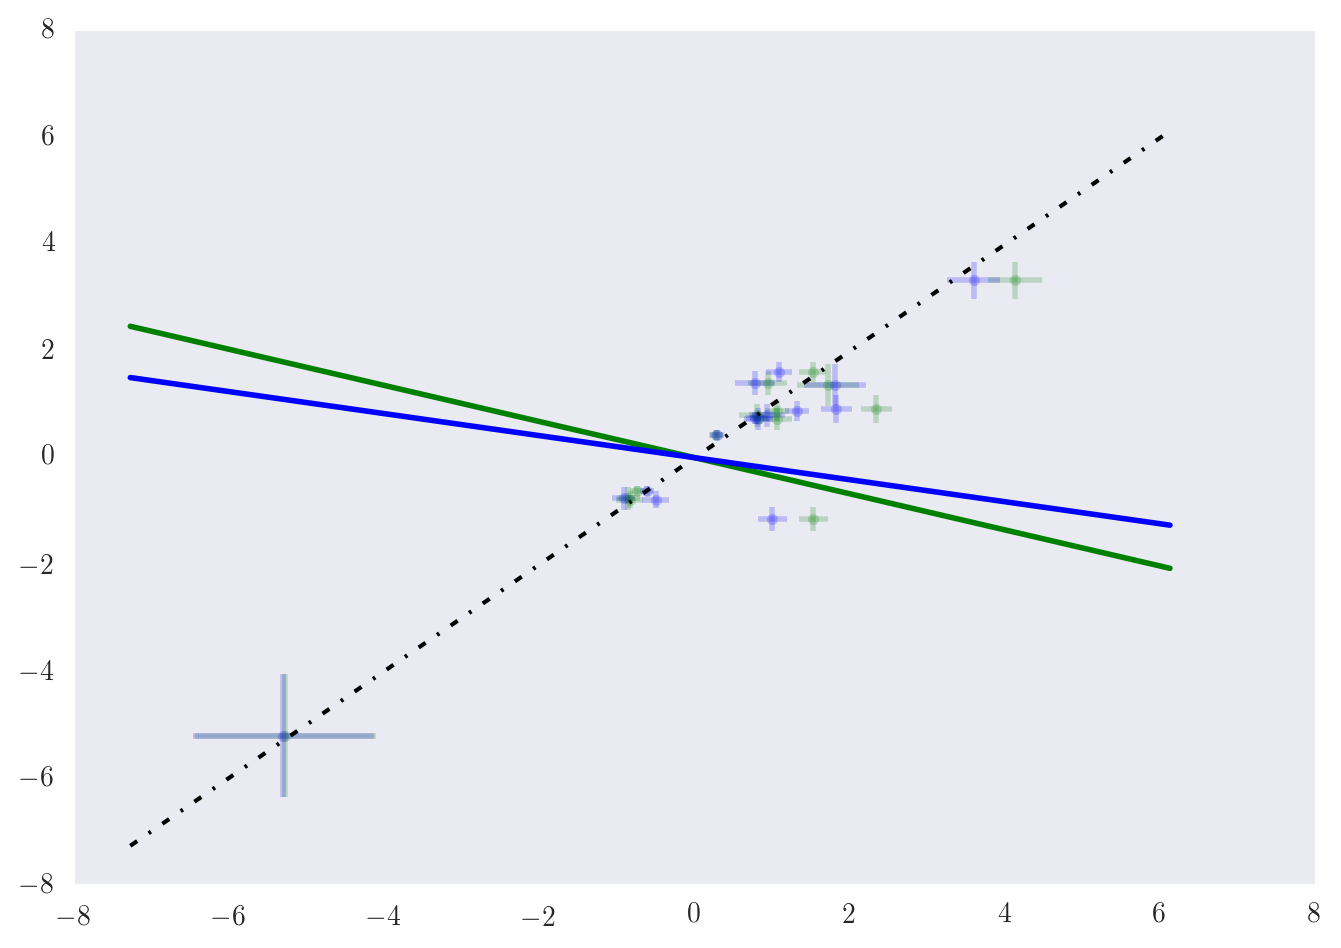

In [926]:
import scipy
import statsmodels.api as sm

def quadrature(x):
    def square(x):
        return x**2
    return np.sqrt(np.sum(x.apply(square)))

double = 'f'
for key in barbara.correlated_genes.keys():
    pair = key[0] + key[1]
    if pair not in d.pair.unique():
        pair = key[1] + key[0]

    pred_genes = barbara.correlated_genes[key]['corr']
    if (pair != thomas.double_muts[double]):
        continue
    
    df_pred = thomas.beta[key[0]].copy()
    df_pred = df_pred[df_pred.target_id.isin(pred_genes)]
    df_test = thomas.beta[double]
    df_test = df_test[df_test.target_id.isin(pred_genes) & (df_test.qval< 0.1)].copy()
    df_pred = df_pred[df_pred.target_id.isin(df_test.target_id)]
    df_test = find_rank(df_test)
    df_pred = find_rank(df_pred)
    
    df_ultimate = thomas.beta[key[1]].copy()
    df_ultimate['b_2'] = thomas.beta[key[0]].b
    df_ultimate['b'] = (df_ultimate.b + df_ultimate.b_2)/2
    df_ultimate = df_ultimate[df_ultimate.target_id.isin(pred_genes)]
    df_ultimate = df_ultimate[df_ultimate.target_id.isin(df_test.target_id)]
    df_ultimate = find_rank(df_ultimate)
    print(len(df_ultimate), len(df_test))
    
    plt.errorbar(df_ultimate.b, df_test.b - df_ultimate.b,
                 xerr=df_ultimate.se_b, yerr=df_test.se_b, fmt='go', alpha=0.2, ms=4)
    plt.errorbar(df_pred.b, df_test.b - df_pred.b,
                 xerr=df_ultimate.se_b, yerr=df_test.se_b, fmt='bo', alpha=0.2, ms=4)
    
    lr = scipy.stats.linregress(df_ultimate.b, df_test.b)
    lr2 = scipy.stats.linregress(df_pred.b, df_test.b)
    
    wls = sm.WLS(df_test.b- df_ultimate.b, df_ultimate.b, weights=1. / df_ultimate.se_b**2)
    res_wls = wls.fit()
    
    wls2 = sm.WLS(df_test.b- df_pred.b, df_pred.b, weights=1. / df_pred.se_b**2)
    res_wls2 = wls2.fit()
    
    slope = res_wls.params
    slope2 = res_wls2.params

    print(key[1], res_wls.summary())
    print(key[0], res_wls2.summary())

    y = x*slope.b
    y2 = x*slope2.b
    plt.plot(x, y, 'g-', lw=2)
    plt.plot(x, y2, 'b-', lw=2)
    prediction = df_ultimate.b + lr.intercept
    mnh = scipy.stats.linregress(df_ultimate.b, df_test.b - prediction)

    plt.xlim(-8,8)
    plt.ylim(-8,8)
    # plt.xscale('symlog')
    # plt.yscale('symlog')
    print(key[1], lr)
    print(key[0], lr2)
    print(df_pred.b.abs().mean())
    print(
"""
{0}: mean b = {3:.2g} +/- {6:.2g}
{1}: mean b = {4:.2g} +/- {7:.2g}
{2}: mean b = {5:.2g} +/- {8:.2g}
""".format(key[0], key[1], pair,
          df_pred.b.abs().mean(), df_ultimate.b.abs().mean(), df_test.b.abs().mean(),
          (df_pred.b.abs().std() + quadrature(df_pred.se_b))/np.sqrt(len(df_pred)),
          (df_ultimate.b.abs().std() + quadrature(df_pred.se_b))/np.sqrt(len(df_pred)),
          (df_test.b.abs().std() + quadrature(df_pred.se_b))/np.sqrt(len(df_pred)),
          )
)

In [927]:
for key, value in thomas.double_muts.items():
    x = thomas.beta_filtered[key]
    y = thomas.beta_filtered[value[0]]
    z = thomas.beta_filtered[value[1]]
    
    x = x[x.qval < thomas.q]
    y = y[y.qval < thomas.q]
    z = z[z.qval < thomas.q]
    
    yANDz = len(y[y.target_id.isin(z)])
    yORz = len(y) + len(z)
    expected = yORz - yANDz
    
    pred1 = x[(x.target_id.isin(z.target_id))]
    pred2 = x[x.target_id.isin(y.target_id)]
    
    pred = len(list(set(pred1.target_id.tolist() + pred2.target_id.tolist())))
    
    print('Expected: ', expected)
    print('Observed: ', len(x))
    print('Predicted: ', pred)
    print('Observed/Expected: {0:.2g}'.format(len(x)/expected))
    print('Predicted/Expected: {0:.2g}'.format(pred/expected))
    print('Surprise factor: {0:.2g}'.format(pred/len(x)))

Expected:  1360
Observed:  144
Predicted:  85
Observed/Expected: 0.11
Predicted/Expected: 0.062
Surprise factor: 0.59
Expected:  1468
Observed:  1513
Predicted:  879
Observed/Expected: 1
Predicted/Expected: 0.6
Surprise factor: 0.58


Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 secComplex Regulation at Work


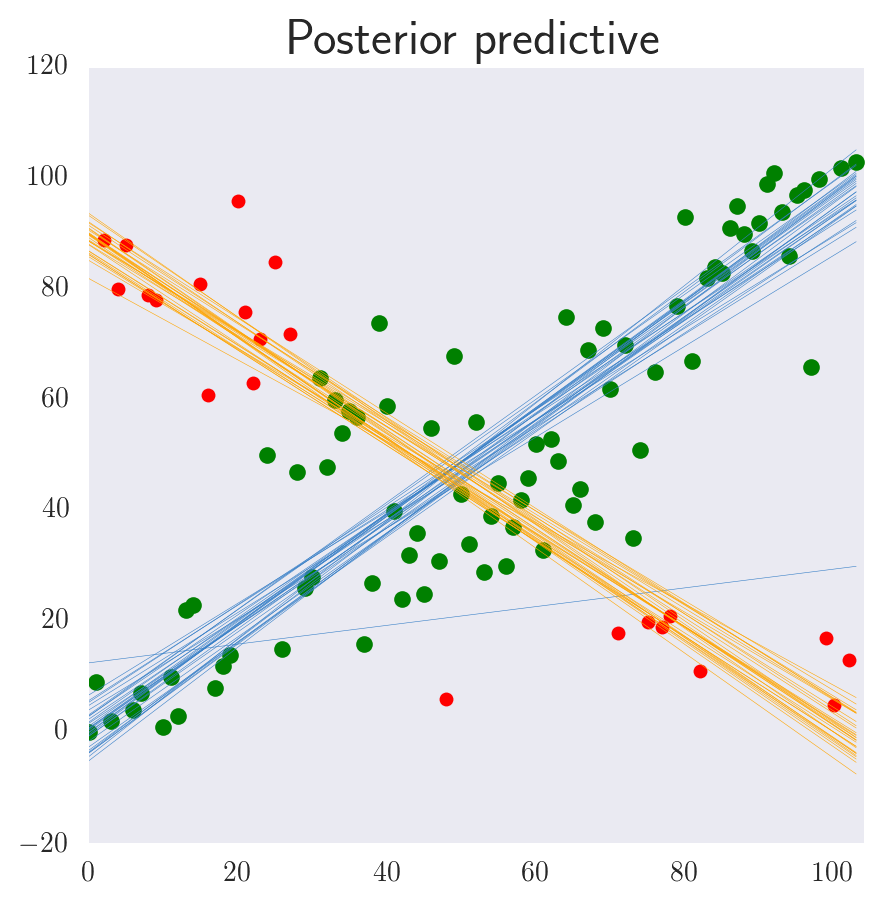

In [928]:
letters = ['a', 'c']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y.target_id.isin(ovx.target_id)].copy()
ovx = x[lind(x) & x.target_id.isin(ovy.target_id)].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

plt.plot(ovx.r, yri, 'go', ms = 6)
plt.plot(ovx.r, yro, 'ro', ms = 5)
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')
plt.xlim(0, len(ovx))
# plt.legend()

if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
    t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
    t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
    if t1 == -t2:
        print('Complex Regulation at Work')

In [929]:
trace_robust.x.mean()

0.93629363528539078

# Defining the Hypoxia Response

In [930]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

# make sure they all go in the same direction:
ind4 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4].copy()

In [931]:
len(hypoxia_genes)

194

In [932]:
tissue_df = tea.fetch_dictionary()
df_res, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene, tissue_df, save=False)

Executing script

Analysis returned no enriched tissues.


In [933]:
hypoxia_genes['avg_qval'] = (hypoxia_genes.qval + hypoxia_genes.e_qval + hypoxia_genes.d_qval)/3
hypoxia_genes['avg_b'] = (hypoxia_genes.b + hypoxia_genes.d_b + hypoxia_genes.e_b)/3
hypoxia_genes.sort_values(['avg_qval'], inplace=True)
hypoxia_genes.to_csv('../output/hypoxia_high_confidence.csv', index=False)

# The genes upregulated by egl-9 should be down in Hif-1.

However, egl-9 and hif-1 seem to have a positive primary relationship under normoxic conditions. Are the secondary genes associated with the hypoxia response?

In [934]:
# First, identify the genes that are outliers in the bc, ec response and intersect them.
if ('c', 'b') in barbara.correlated_genes.keys():
    key = ('c', 'b')
else:
    key = ('b', 'c')

if ('c', 'e') in barbara.correlated_genes.keys():
    key2 = ('c', 'e')
else:
    key2 = ('e', 'c')

print(key)
bc_in = barbara.correlated_genes[key]['corr']
ec_in = barbara.correlated_genes[key2]['corr']
bec_in = np.intersect1d(bc_in, ec_in)
print("""
There are {0} genes that are inliers in the BC intersection,
There are {1} genes that are inliers in the EC intersection,
and there are {2} genes in the BEC inliers intersection.
""".format(len(bc_in), len(ec_in), len(bec_in)))


bc = barbara.correlated_genes[key]['outliers'].target_id
ec = barbara.correlated_genes[key2]['outliers'].target_id
bec = np.intersect1d(bc, ec)
print("""
There are {0} genes that are outliers in the BC intersection,
There are {1} genes that are outliers in the EC intersection,
and there are {2} genes in the BEC outlier intersection.
""".format(len(bc), len(ec), len(bec)))

print(
"""
{0:.2g} of the genes in the BEC intersection are outliers
""".format(len(bec)/(len(bec) + len(bec_in)))
)

('c', 'b')

There are 60 genes that are inliers in the BC intersection,
There are 80 genes that are inliers in the EC intersection,
and there are 42 genes in the BEC inliers intersection.


There are 18 genes that are outliers in the BC intersection,
There are 17 genes that are outliers in the EC intersection,
and there are 7 genes in the BEC outlier intersection.


0.14 of the genes in the BEC intersection are outliers



In [935]:
intersection = hypoxia_genes[hypoxia_genes.target_id.isin(bec)].ext_gene.unique()
print(
"""
There are {} genes from the BEC intersection in the hypoxia set!
""".format(len(intersection))
)



There are 3 genes from the BEC intersection in the hypoxia set!



In [936]:
q = 0.1
L = thomas.beta_filtered['a'].shape[0] # total genes measured for any experiment

p = stats.hypergeom.sf(len(intersection), L, len(bec), len(hypoxia_genes))

if p < 10**-3:
    print(
"""
This result is statistically significant, with p-value = {0:.2g}
""".format(p)
    )


This result is statistically significant, with p-value = 1.7e-06



In fact, it does seem that hypoxia related genes are under control of *hif-1* under normoxic conditions, and that knocking *hif-1* out in a normoxic animal causes changes in this gene set. However, this is not the PRIMARY role of *hif-1* under physiologic conditions

In [937]:
intersection

array(['R08E5.3', 'Y37A1B.5', 'nit-1'], dtype=object)

In [938]:
temp = thomas.beta_filtered['c']
temp[temp.target_id.isin(intersection)].qval.values

array([ 0.00464355])

Unfortunately, none of them are immediately associated with the hypoxia pathway, but a number of these are stress response genes! Thankfully, the q-values are also reasonably low for most of these genes. We're all good. 

# Tissue and Phenotype Enrichment Analyses:

In [939]:
thomas.enrichment_analysis(x='ens_gene', analysis='tissue')

Executing script

Executing script

Executing script

Executing script

Executing script

Executing script

Executing script



In [940]:
df_phe, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene.unique(), phenotype_df, show=False, save=False)
df_phe.head()

Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
0,neuron development variant WBPhenotype:0000816,0.693391,5,7.210938,0.000063,0.014559


# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [941]:
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [942]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS, col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0], ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        nhr57 = np.exp(found[found.ens_gene == 'WBGene00003647'].b.values[0])
        print('nhr-57 is in', sm, 'and its fold change was {0:.2g}'.format(nhr57))
    
    print('----------')

genotype:  c
found:  1       Mean b: 0.46
pval: 0.069
Maximum change was:
rhy-1
1.59083900252  fold change
----------
genotype:  e
found:  9       Mean b: 2.5
pval: 5.3e-05
Maximum change was:
npp-6
45.4874469342  fold change
nhr-57 is in e and its fold change was 45
----------
genotype:  d
found:  7       Mean b: 2.2
pval: 6.7e-08
Maximum change was:
dod-3
44.902112704  fold change
nhr-57 is in d and its fold change was 7
----------
genotype:  g
found:  3       Mean b: -1.7
pval: 0.14
Maximum change was:
cysl-2
0.253051000866  fold change
----------
genotype:  b
found:  9       Mean b: 2.6
pval: 2.7e-06
Maximum change was:
oac-54
66.1137784328  fold change
nhr-57 is in b and its fold change was 62
----------


In [66]:
G=nx.Graph()

mutant_dict = {'b': 'egl-9',
               'c': 'hif-1',
               'e': 'rhy-1',
               'd': 'vhl-1',
               'g': 'fog-2'
              }

# for i in single_mutants:
#     G.add_node(i)

for i, key in enumerate(thomas.single_mutants):
    for j, key2 in enumerate(thomas.single_mutants):
        df = d
        r = d[(d.variable == key) & (d.corr_with == key2) &
              (d.regression == 'primary')].corrected.values
        if r:
            G.add_edge(mutant_dict[key], mutant_dict[key2], weight=r[0])
            print(mutant_dict[key], mutant_dict[key2])


elarge=[(u,v) for (u,v,d) in G.edges(data=True)]
width=[15*d['weight'] for (u,v,d) in G.edges(data=True)]
print(width)
weights=[d['weight'] for (u,v,d) in G.edges(data=True)]
# edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

fig, ax = plt.subplots()

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='g', alpha=.5)

# edges
edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=width, edge_color=weights,
                       edge_cmap=plt.cm.viridis)
# edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
#                        width=width)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif')

fig.colorbar(edges)

# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig("../output/weighted_graph.pdf") # save as png
plt.show() # display

NameError: name 'd' is not defined

# An *in silico* qPCR experiment:

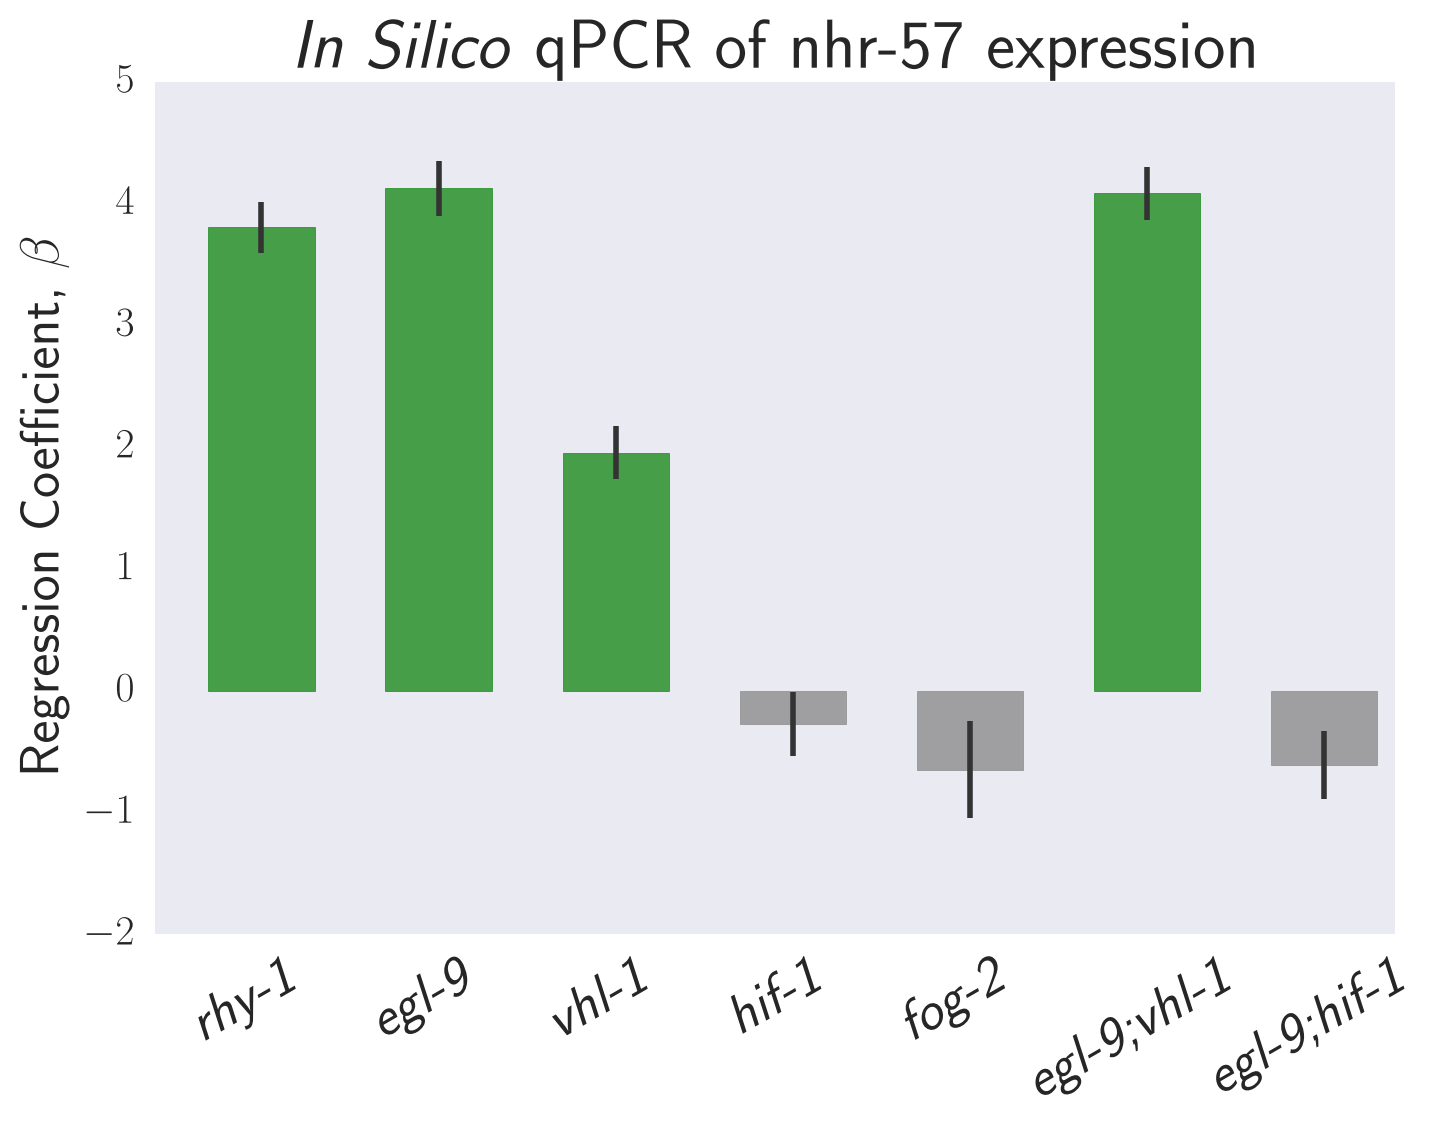

In [944]:
# nhr-57
nhr = 'WBGene00003647'
data = np.array([])
sorter = {'a': 6,
          'f': 7,
          'b': 2,
          'c': 4,
          'd':3,
          'e': 1,
          'g': 5
         }

g = []
for genotype, df in thomas.beta_filtered.items():
    x = genotype_mapping[genotype]
    y = df[(df.ens_gene == nhr)][['b', 'se_b', 'qval']].values
    if len(data) == 0:
        data = y
    else:
        data = np.vstack((data, y))
    g += [genotype]

d = pd.DataFrame(data, columns=['b', 'se_b', 'qval'])
d['code'] = g
d['genotype'] = d.code.map(genotype_mapping)
d['order'] = d.code.map(sorter)
d.sort_values('order', inplace=True)

# a qPCR barplot
temp = d#[(d.code != 'a') &( d.code != 'f')]

index = np.linspace(0, temp.shape[0]-1, temp.shape[0])
bar_width = 0.6
alpha = 0.7
error_config = {'ecolor': '0.2'}
barlist = plt.bar(index+0.3, temp.b.values, bar_width, alpha=alpha, yerr=temp.se_b, error_kw=error_config)
for i, genotype in enumerate(temp.genotype):
    if temp[temp.genotype == genotype].qval.values[0] < 0.1:
        barlist[i].set_color('g')
    else:
        barlist[i].set_color('0.5')

plt.xticks(index + 1/2, temp.genotype, rotation=30, fontsize=20)
plt.yticks(fontsize=15)

pathify(r'\emph{In Silico} qPCR of nhr-57 expression', '', r'Regression Coefficient, $\beta$' )
# plt.ylabel('Regression Coefficient', fontsize=20).set_path_effects([path_effects.Normal()])
# plt.title(r'\emph{In Silico} qPCR of nhr-57 expression', fontsize=25).set_path_effects([path_effects.Normal()])
plt.savefig('../output/nhr57qPCR.pdf', bbox_inches='tight')

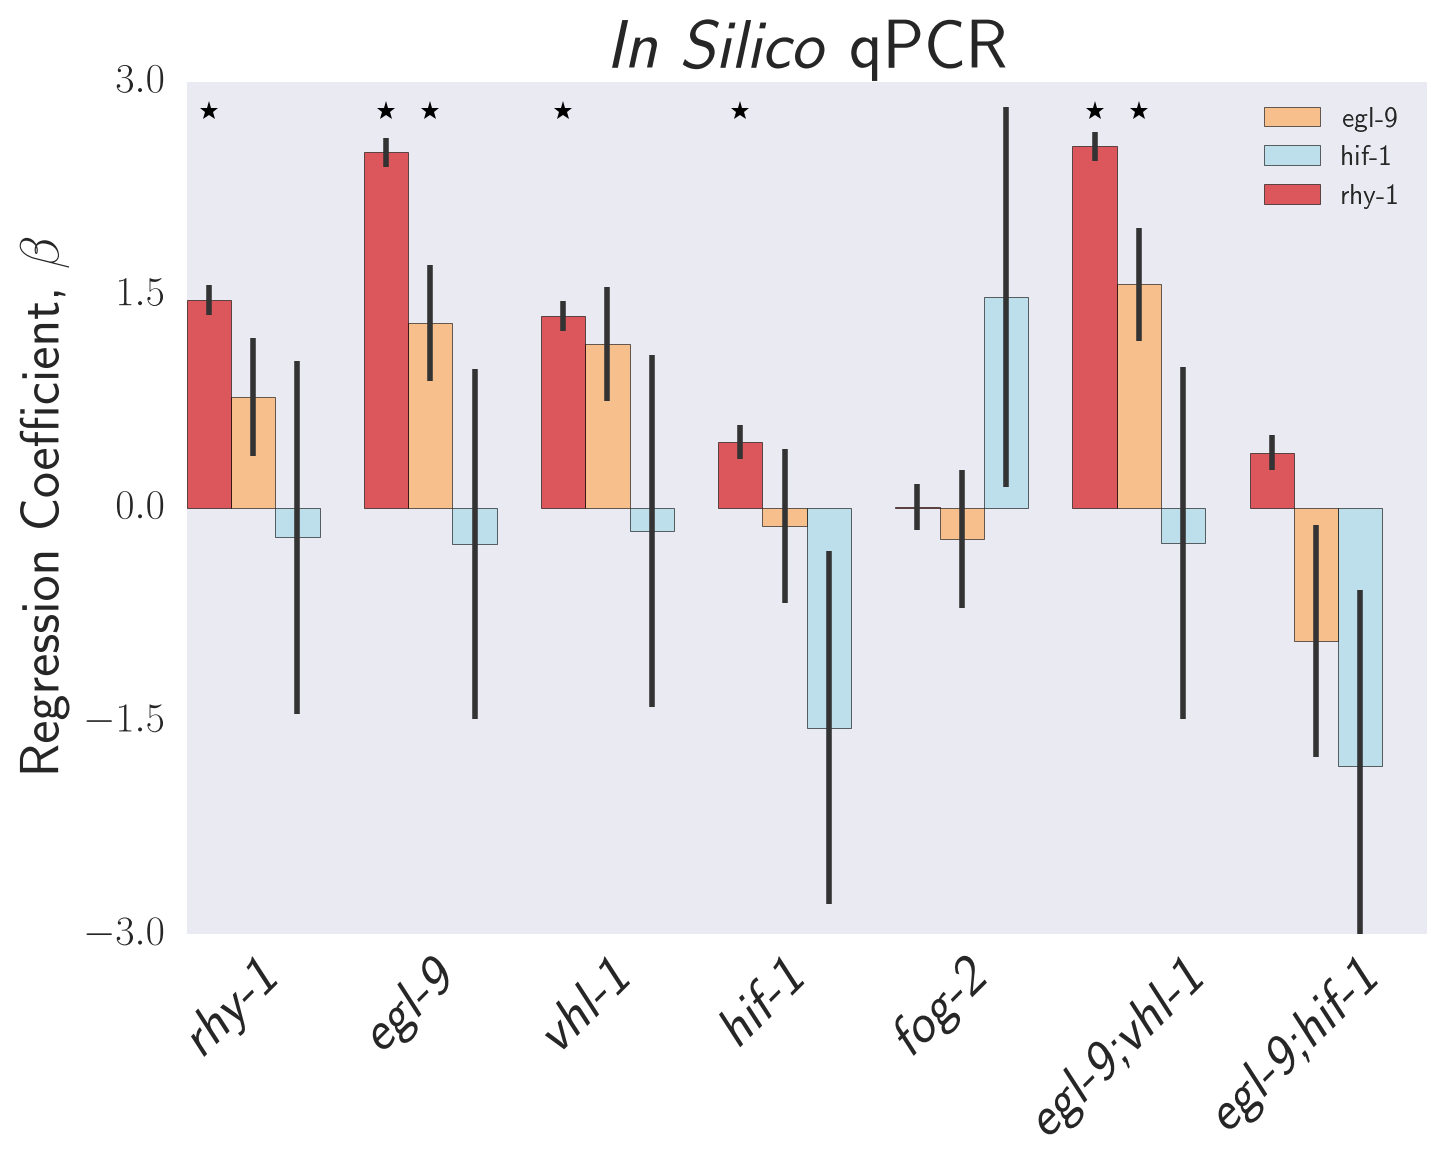

In [945]:
x = ['WBGene00001851',
     'WBGene00012324',
     'WBGene00001178',
     'WBGene00006922']

# run the experiment!
g = []
data = np.array([])
i = 0
for genotype, df in thomas.beta_filtered.items():
    for j, xi in enumerate(x):
        geno = genotype_mapping[genotype]
        y = df[(df.ens_gene == xi)][['ext_gene','b', 'se_b', 'qval']].values
        if len(y) == 0:
            continue
        # hif has two isoforms, so take F38A6.3c
        if y.shape[0] > 1:
            y = df[(df.target_id == 'F38A6.3c')][['ext_gene','b', 'se_b', 'qval']].values
        if len(data) == 0:
            data = y
        else:
            data = np.vstack((data, y))
        g += [genotype]
    i += 1

d = pd.DataFrame(data, columns=['ext_gene', 'b', 'se_b', 'qval'])
d['code'] = g
d['genotype'] = d.code.map(genotype_mapping)
d['order'] = d.code.map(sorter)
d.sort_values('order', inplace=True)
d.reset_index(inplace=True)    

# a qPCR barplot
temp = d
index = np.linspace(0, temp.genotype.unique().shape[0]-1, temp.genotype.unique().shape[0])
bar_width = 0.25
alpha = 0.7
error_config = {'ecolor': '0.2'}

plotting = {'rhy-1': 0,
            'egl-9': 1,
            'hif-1': 2,
            }

color = {'rhy-1': "#d7191c",
        'egl-9': '#fdae61',
        'hif-1': '#abd9e9',
        }

grouped = temp.groupby('ext_gene')
for name, group in grouped:
    add = plotting[name]*bar_width
    barlist = plt.bar(index + add, group.b.values, bar_width, alpha=alpha,
                      yerr=group.se_b, error_kw=error_config, label=name,
                      color=color[name])
    sig = group.qval < 0.1
    k = group[sig].order -1 
    plt.plot(k + add + bar_width/2, np.repeat(temp.b.max() + 0.25, len(k)), r'*', color='k')

plt.xticks(index + bar_width, temp.genotype.unique(), rotation=45, fontsize=20)
plt.ylim(-3, 3)
plt.yticks([-3, -1.5, 0, 1.5, 3], fontsize=15)
# plt.ylabel('Regression Coefficient', fontsize=20)
# plt.title(r'\emph{In Silico} qPCR', fontsize=25)
pathify(r'\emph{In Silico} qPCR', '', r'Regression Coefficient, $\beta$')
plt.legend()
plt.savefig('../output/pathwaygenes_qPCR.pdf', bbox_inches='tight')

# Define the Absolute Gold Set 
by Finding the Intersection Between the Double Mutant that is Constitutively Hypoxic and the single mutants that are also hypoxic

In [946]:
# gene should be in double constitutive:
temp = thomas.beta_filtered['a']
temp = temp[temp.qval < 0.1]
temp = temp[temp.target_id.isin(hypoxia_genes.target_id)]

# should not be in the genes that go up in hif-1 mutants:
nothif1 = thomas.beta_filtered['f']
nothif1 = nothif1[(nothif1.qval < 0.1) & (nothif1.b > 0)]
nothif2 = thomas.beta_filtered['c']
nothif2 = nothif2[(nothif2.qval < 0.1) & (nothif2.b > 0)]

ind1 = ~temp.target_id.isin(nothif1.target_id)
ind2 = ~temp.target_id.isin(nothif2.target_id)
temp = temp[(ind1) & (ind2)]
temp.shape

(167, 14)

In [947]:
temp['b_sm'] = hypoxia_genes.b
temp['qval_avg_sm'] = hypoxia_genes.avg_qval
temp['avg_b_sm'] = hypoxia_genes.avg_b

gold = temp[temp.b*temp.b_sm > 0]

In [948]:
gold.head()

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,b_sm,qval_avg_sm,avg_b_sm
81,1023,B0205.11,9.879500e-04,1.749338e-02,-0.332931,0.101074,6.226705,0.149907,0.002921,0.012403,0.012191,0.012403,WBGene00015025,mrpl-9,-0.371011,0.026533,-0.411685
96,97,B0213.14,5.879967e-17,1.098038e-14,-1.014352,0.121224,5.638385,0.383661,0.003671,0.014264,0.018372,0.018372,WBGene00015043,cyp-34A8,-0.768167,0.030131,-0.569256
152,670,B0272.3,7.819931e-05,2.114182e-03,-0.402694,0.101952,6.160901,0.119528,0.002928,0.006502,0.012663,0.012663,WBGene00007129,B0272.3,-0.310404,0.025448,-0.388569
181,221,B0286.3,6.374449e-10,5.224741e-08,-0.595824,0.096398,6.260179,0.331209,0.001967,0.006894,0.011972,0.011972,WBGene00015116,B0286.3,-0.512449,0.000533,-0.561461
238,559,B0350.2a.1,2.296034e-05,7.440135e-04,0.452169,0.106796,7.436306,0.982278,0.004043,0.013065,0.009046,0.013065,NaN,NaN,0.441391,0.038123,0.368901


In [949]:
ind = (genpy.find(hypoxia_genes, hypoxia_gold.WBIDS, col='ens_gene'))
found = hypoxia_genes[ind].ens_gene.unique()
sig = len(hypoxia_genes)
pval = stats.hypergeom.sf(len(found), len(thomas.beta_filtered['a']), len(hypoxia_gold), sig)    

In [950]:
pval

4.7909774079466932e-07

In [951]:
hypoxia_genes[ind].ext_gene.unique()

array(['rhy-1', 'nhr-57', 'oac-54', 'phy-2', 'cysl-2'], dtype=object)

In [952]:
len(gold)

167

In [953]:
gold[gold.target_id.isin(tf_df.target_id)][['ext_gene', 'qval_avg_sm', 'avg_b_sm']]

,ext_gene,qval_avg_sm,avg_b_sm
3726,F17C11.1,1.681476e-02,0.775391
8339,nhr-57,1.197171e-16,3.292807
9593,W02D7.6,5.141443e-02,0.307505


# Hypoxia Positive Interaction

In [954]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']
ovc = thomas.beta_filtered['c']
ova = thomas.beta_filtered['a']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval
ovb['c_qval'] = ovc.qval
# ovb['a_qval'] = ova.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b
ovb['c_b'] = ovc.b
# ovb['a_b'] = ova.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
# ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)
ind4 = (ovb.c_qval < 0.1)
# ind5 = (ovb.a_qval < 0.1)

i1 = ind1 & ind2 & ind3 & ind4 #& ind5

# make sure they all go in the same direction:
# ind5 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)
# ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0) & (ovb.d_b*ovb.c_b >0)

ind5 =  (ovb.b*ovb.e_b > 0)
ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0)
# ind7 = (ovb.b*ovb.a_b > 0) & (ovb.c_b*ovb.a_b > 0) & (ovb.e_b*ovb.a_b > 0)

i2 = ind5 & ind6 #& ind7

# novel_response = ovb[ind1 & ind2 & ind3 & ind4 & ind5 & ind6].copy()
novel_response = ovb[i1 & i2].copy()


novel_response['avg_qval'] = (ovb.qval + ovb.d_qval + ovb.e_qval + ovb.c_qval)/4
novel_response['avg_b'] = (ovb.b + ovb.d_b + ovb.e_b + ovb.c_b)/4
novel_response.sort_values(['avg_qval'], inplace=True)

In [955]:
len(novel_response.ens_gene.unique())

8

# Searching for a TF that is activated by both egl-9 and hif-1
And possibly regulates rhy-1 as a result

In [956]:
# Figure out how many hits we get and if the pvalue is significant!
tfs = {}
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, tf_df.target_id, col='target_id'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    tfs[sm] = found.copy()
        
    print('----------')

genotype:  c
found:  9       Mean b: 0.093
pval: 3.4e-12
----------
genotype:  e
found:  17       Mean b: 0.41
pval: 1.7e-14
----------
genotype:  d
found:  6       Mean b: 0.74
pval: 1.3e-06
----------
genotype:  g
found:  23       Mean b: 0.13
pval: 0
----------
genotype:  b
found:  9       Mean b: 1.1
pval: 2.7e-06
----------


In [957]:
def add_b(x):
    vals = tfs['c'][tfs['c'].target_id == x]
    if len(vals):
        return vals.b.values[0]
    else:
        return np.nan

temp = tfs['b']
temp['b_c'] = temp.target_id.apply(add_b)

In [958]:
temp[(temp.b_c < 0) & (temp.b < 0)][['ext_gene','b_c','b', 'qval']]

,ext_gene,b_c,b,qval
5330,mxl-3,-0.916208,-0.796353,0.000003


In [959]:
# mxl-3 should be down in the egl, hif double:
temp = thomas.beta_filtered['f']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5330,mxl-3,-0.760397,0.056427


In [960]:
temp = thomas.beta_filtered['a']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5330,mxl-3,-0.33456,0.081762


In [961]:
temp = thomas.beta_filtered['e']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5330,mxl-3,-0.362074,0.053991


In [962]:
temp = thomas.beta_filtered['d']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

,ext_gene,b,qval
5330,mxl-3,-0.387901,0.270525


In [963]:
# hypoxia_genes.to_csv('../hypoxia_genes.csv',index=False)
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.core.display import HTML

# Use Bokeh chart to make plot
hypoxia_genes['logq'] = -np.log(hypoxia_genes.avg_qval)
hypoxia_genes['logq'] = hypoxia_genes['logq'].astype(np.float64)
hypoxia_genes['avg_b'].astype(np.float64)
hypoxia_genes.logq.fillna(700, inplace=True)
hypoxia_genes.logq.replace([np.inf], 700, inplace=True)
hypoxia_genes.logq.replace([-np.inf], 0, inplace=True)

hypoxia_genes.b.replace([np.inf], 6, inplace=True)
hypoxia_genes.b.replace([-np.inf], -6, inplace=True)
hypoxia_genes.dropna(inplace=True)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='b'
p.yaxis.axis_label ='-log(Q)'

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
source1 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b < 0])
source2 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b > 0])
# Specify data source
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source1, color='blue')
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source2, color='red')
p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
html = file_html(p, CDN, "my plot")
HTML(html)

In [964]:
bs = np.array([])
for key in thomas.beta.keys():
    df = thomas.beta_filtered[key]
    if len(bs) == 0:
        bs = df.b.values
        qs = df.qval.values
    else:
        bs = np.vstack((bs, df.b.values))
        qs = np.vstack((qs, df.qval.values))

In [965]:
b_df = pd.DataFrame(np.transpose(bs), columns = thomas.beta.keys())
q_df = pd.DataFrame(np.transpose(qs), columns = thomas.beta.keys())
b_df = pd.melt(b_df, var_name='genotype', value_name='b')
q_df = pd.melt(q_df, var_name='genotype', value_name='q')
b_df['abs b'] = b_df.b.abs()
b_df['sorter'] = b_df.genotype.map(sorter)
q_df['sorter'] = q_df.genotype.map(sorter)
b_df.sort_values('sorter', inplace=True)
q_df.sort_values('sorter', inplace=True)
b_df['names'] = b_df.genotype.map(genotype_mapping)

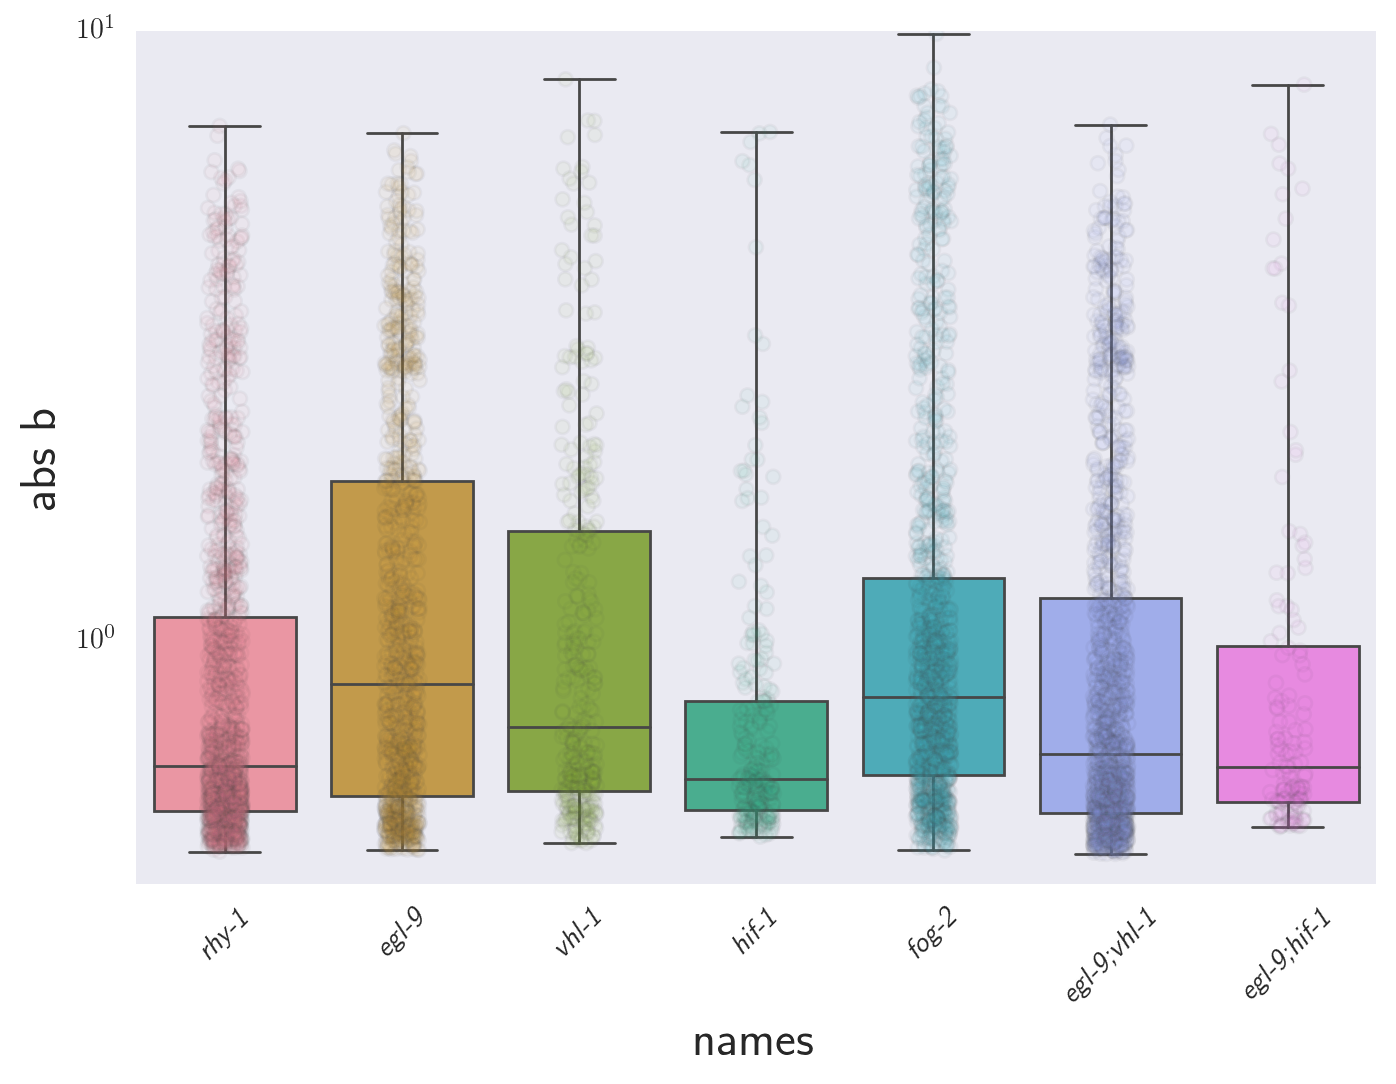

In [966]:
sns.boxplot(x="names", y="abs b", data=b_df[q_df.q < 0.1], whis=np.inf, linewidth=1)
sns.stripplot('names', 'abs b', data=b_df[q_df.q < 0.1], linewidth=1, jitter=True, alpha=0.05)
plt.xticks(rotation=45)
plt.ylim(10**-1, 10)
plt.yscale('symlog')

In [967]:
for genotype in b_df.genotype.unique():
    print(genotype, b_df[(b_df.genotype == genotype) & (q_df.q < 10**-1)].shape[0])

e 1525
b 1094
d 374
c 266
g 1263
a 1513
f 144


Knocking out *hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Knocking out *vhl-1* should increase levels of both forms. 

Knocking out *egl-9* or *rhy-1* should decrease the hydroxylated form and increase the non-hydroxylated form. 

Knocking out *egl-9;hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Therefore:
Overlap *hif-1*, *egl-9* and *rhy-1* mutants with coexpression and find only targets that go DOWN. Next, overlap *vhl-1* with anti-expression. These are the hydroxylated targets of *hif-1* and possibly some other stuff

In [968]:
df1 = thomas.beta['f'].copy() # egl-9;hif-1 double mutant
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] # egl-9; vhl-1 double should also decrease hydroxylation of hif
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b


df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

ind = (df1.qval < 0.1) & (df1.q_c < 0.1) & (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b < 0) & (df1.b_c < 0) & (df1.b_e < 0) & (df1.b_b < 0) & (df1.b_a < 0)
ind3 = (df1.b_d > 0)

df1[ind & ind2 & ind3][['ext_gene', 'b_d', 'q_d']]


,ext_gene,b_d,q_d
9850,F20D6.11,0.584984,0.000161


We find two genes. . It's possible that we just couldn't measure the hydroxylated *hif-1* targets properly because 
A less stringent filter would be to just anti-overlap the *vhl-1* with the (*egl-9* and *rhy-1*) mutants and see what comes up. This means we are no longer measuring *hif-1* directly, rather, we are inferring it and hoping that the noise from other stuff that these genes have in common gets drowned out. 

In [969]:
ind = (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1) # significant in all relevant depts.
ind2 = (df1.b_e < 0) & (df1.b_b < 0) & (df1.b_a < 0) # loss of egl causes hif-OH to go down
ind3 = (df1.b_d > 0) # vhl causes hif-OH to go UP
hydroxylated_hif = df1[ind & ind2 & ind3]
hydroxylated_hif[['ext_gene', 'b_d', 'q_d', 'b_e']].sort_values('q_d').head()

,ext_gene,b_d,q_d,b_e
15045,F55G11.2,0.850331,0.000028,-0.606049
9850,F20D6.11,0.584984,0.000161,-0.573821
11479,cat-4,0.746605,0.000210,-0.782847
15953,asp-8,0.641849,0.053959,-1.789090


Nope! It looks that even our less stringen filter yields quite the small list of targets!

Let's find the genes associated with non-hydroxylated hypoxia factor next. 

Knocking out *hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Knocking out *vhl-1* should increase levels of both forms. 

Knocking out *egl-9* or *rhy-1* should decrease the hydroxylated form and increase the non-hydroxylated form. 

Knocking out *egl-9;hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Therefore:
Overlap *vhl-1*, *egl-9* and *rhy-1* mutants with coexpression and find only targets that go UP. Next, overlap *hif-1* with anti-expression. These are  targets of non-hydroxylated *hif-1* and possibly some other stuff

In [970]:
ind = (df1.qval < 0.1) & (df1.q_c < 0.1) & (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b_e > 0) & (df1.b_b > 0) & (df1.b_a > 0) & (df1.b_d > 0)
ind3 = (df1.b < 0) & (df1.b_c < 0)
df1[ind & ind2 & ind3][['ext_gene', 'b_e', 'q_e']].sort_values('q_e')

,ext_gene,b_e,q_e
19626,R08E5.3,4.559051,0.000000e+00
31611,nit-1,3.351657,6.396424e-25


Again, we observe only very few genes. Let's try to remove the *hif-1;egl-9* double mutant to increase our sample size:

In [971]:
ind = (df1.q_c < 0.1) & (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b_e > 0) & (df1.b_b > 0) & (df1.b_a > 0) & (df1.b_d > 0)
ind3 = (df1.b_c < 0)
df1[ind & ind2 & ind3][['ext_gene', 'b_e', 'q_e']].sort_values('q_e')

,ext_gene,b_e,q_e
19626,R08E5.3,4.559051,0.000000e+00
26372,Y37A1B.5,2.572321,3.012523e-50
31611,nit-1,3.351657,6.396424e-25


Now we're talking! We can definitely say that these are the best candidates for direct control by *hif-1*. However, the list could probably still be larger. 

Let's weaken the conditions a little bit. Now, we will only require that whatever our candidate genes are, they should not be **significantly upregulated in response to loss of hif-1**.

In [972]:
ind =  (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b_e > 0) & (df1.b_b > 0) & (df1.b_a > 0) & (df1.b_d > 0)
ind3 = ~((df1.q_c < 0.1) & (df1.b_c > 0)) & ~((df1.qval < 0.1) & (df1.b > 0))
hypoxia_direct_targets = df1[ind & ind2 & ind3]
print(hypoxia_direct_targets.shape[0])
hypoxia_direct_targets[['ext_gene', 'b_e', 'q_e']].sort_values('q_e').head()


86


,ext_gene,b_e,q_e
19626,R08E5.3,4.559051,0.000000e+00
4509,C31C9.2,2.450874,2.270418e-84
24060,VF13D12L.3,1.562130,2.975903e-70
21073,nhr-57,3.803574,2.182531e-69
10774,F26H9.5,1.580762,4.335975e-67


Now we're talking! We can definitely say that these are the best candidates for direct control by *hif-1*.

If we are willing to let go of the difference between hydroxylated and non-hydroxylated *hif-1*, we could remove the *hif-1* filters entirely. However, I think these 167 genes are probably enough for now. Let's take a moment now to verify that this result matches what is known in the literature:

In [973]:
_ = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(), tissue_df, show=True)
_ = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(), phenotype_df, show=True)

Executing script

Analysis returned no enriched tissues.
Executing script

                                           Tissue  Expected  Observed  \
0  neuron development variant WBPhenotype:0000816  0.277356         3   

   Enrichment Fold Change   P value   Q value  
0               10.816406  0.000159  0.036961  


In [974]:
ind = hypoxia_direct_targets.ens_gene.isin(hypoxia_gold.WBIDS)
found = hypoxia_direct_targets[ind].ens_gene.unique()
sig = len(hypoxia_direct_targets)
pval = stats.hypergeom.sf(len(found), len(thomas.beta_filtered['a']), len(hypoxia_gold), sig)    

if pval < 10**-3:
    print('This result is statistically significant \
with a p-value of {0:.2g} using a hypergeometric test. You found {1} gold standard genes!'.format(pval, len(found)))

This result is statistically significant with a p-value of 2.2e-07 using a hypergeometric test. You found 4 gold standard genes!


Very nice! We are actually sampling from the hif-1 pool! Fantastic! 

Next, let's identify rhy-1 associated genes. We will also insist that rhy-1 genes NOT be associated with hif-1 (they really shouldn't be, the logic between these two sets is mutually exclusive, I think, but it's best to make sure; let's hit stuff with a hammer):

In [975]:
ind =  (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_c < 0.1)
ind2 = (df1.b_e*df1.b_b > 0) & (df1.b_e*df1.b_a > 0) & (df1.b_c*df1.b_e > 0) & (df1.b_c*df1.b_b > 0)
ind3 = (~df1.target_id.isin(hypoxia_direct_targets.target_id))
rhy1_targets = df1[ind & ind2 & ind3]
print(rhy1_targets.shape)
rhy1_targets[['ext_gene', 'b_e', 'q_e']].sort_values('q_e').head()

(35, 24)


,ext_gene,b_e,q_e
24825,rhy-1,1.463342,3.043248e-39
31240,ZC317.7,2.126488,2.822275e-34
22384,T15B7.1,-0.894958,8.061431e-23
30446,hil-2,0.646204,3.271025e-11
14917,col-155,0.637268,3.736810e-11


In [976]:
_ = tea.enrichment_analysis(rhy1_targets.ens_gene.unique(), tissue_df, show=True)
_ = tea.enrichment_analysis(rhy1_targets.ens_gene.unique(), phenotype_df, show=False)
_[0].head()

Executing script

Analysis returned no enriched tissues.
Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value


In [977]:
rhy1_targets[(rhy1_targets.b_e <= rhy1_targets.b_e.min() + 1.5)][['ext_gene','b_e']]

,ext_gene,b_e
1082,C01G10.8,-0.524032
6992,acdh-1,-0.495812
9850,F20D6.11,-0.573821
12331,dnj-12,-0.548035
12995,msra-1,-1.340053
13549,mxl-3,-0.362074
14659,F54D5.12,-0.645662
18340,tra-3,-0.326161
20316,pfd-5,-0.536414
20809,lis-1,-0.360747


OK! We found 'em. Let's find the *egl-9* related genes next.

In [978]:
ind =  (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d > 0.1) & (df1.q_c > 0.1)
ind2 = (df1.b_e*df1.b_b > 0) & (df1.b_e*df1.b_a > 0) & (df1.b_b*df1.b_a > 0)
#         & (df1.b_c*df1.b_e < 0) & (df1.b_c*df1.b_b < 0)\
#         & (df1.b_b*df1.b_d > 0) & (df1.b_e*df1.b_d > 0)
ind3 = True
ind4 = (~df1.target_id.isin(hypoxia_direct_targets.target_id))
egl_targets = df1[ind & ind2 & ind3  & ind4]
print(egl_targets.ens_gene.unique().shape[0])
egl_targets[['ext_gene', 'b_b', 'q_b']].sort_values('q_b').head(10)

385


,ext_gene,b_b,q_b
3558,C18H9.6,-3.037352,8.829686e-68
10340,sqt-3,3.933183,4.239415e-42
9265,far-3,4.387022,5.391423e-31
9320,pud-2.2,-2.908717,1.631023e-29
9314,pud-2.1,-2.908717,1.631023e-29
1197,tyr-1,1.592028,3.349766e-27
18219,K11G12.5,0.922823,1.536410e-23
25790,col-120,4.843748,9.098140e-22
15295,cdo-1,2.157294,4.740228e-21
18213,nas-11,1.506569,1.299979e-20


In [979]:
_ = tea.enrichment_analysis(egl_targets.ens_gene.unique(), tissue_df, show=True)
_ = tea.enrichment_analysis(egl_targets.ens_gene.unique(), phenotype_df, show=False)
_[0].head(10)

Executing script

Analysis returned no enriched tissues.
Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
0,neuron morphology variant WBPhenotype:0000905,10.558072,44,4.167428,4.153545e-17,9.636225e-15
30,vulval cell induction reduced WBPhenotype:0000219,25.005959,68,2.719352,6.653668e-16,7.718255e-14
2,mid larval arrest WBPhenotype:0001019,11.137920,43,3.860685,1.690125e-15,1.307030e-13
37,early larval lethal WBPhenotype:0000057,15.535103,48,3.089777,2.346621e-13,1.361040e-11
32,serotonin response variant WBPhenotype:0001232,6.595775,30,4.548366,4.135423e-13,1.918836e-11
46,intestinal cell development variant WBPhenotyp...,3.624052,21,5.794619,8.251012e-12,3.190391e-10
35,embryonic cell morphology variant WBPhenotype:...,34.114410,73,2.139858,1.291190e-11,4.279374e-10
42,coiling variant WBPhenotype:0002297,51.993066,94,1.807933,8.681126e-11,2.517527e-09
50,RNA expression variant WBPhenotype:0000113,17.661213,46,2.604578,3.166112e-10,8.161534e-09
12,lipid metabolism variant WBPhenotype:0000725,43.440303,82,1.887648,3.271409e-10,8.161534e-09


Next, let's find the vhl-related genes.

In [980]:
ind =  (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b_d > 0) & (df1.b_a > 0)
ind4 = (df1.q_e > 0.1) & (df1.q_b > 0.1) & (df1.q_b > 0.1)

vhl_targets = df1[ind & ind2 & ind4]
print(vhl_targets.shape[0])
vhl_targets[['ext_gene', 'b_d', 'q_d', 'b_b', 'b_e']].sort_values('q_d').head(10)

16


,ext_gene,b_d,q_d,b_b,b_e
11227,F31C3.4,0.551953,0.000002,-0.054173,0.050970
24756,hgo-1,0.496430,0.000005,0.084007,-0.111131
11226,F31C3.3,0.504726,0.000783,0.093656,0.043367
3822,sdc-3,0.670540,0.006145,0.454648,0.078107
11228,psf-2,0.588508,0.007565,0.209216,0.076102
20956,T04D3.5,0.351590,0.009098,0.215341,0.151298
11606,F33H2.6,0.386294,0.013383,-0.142987,-0.218383
1132,cam-1,0.389337,0.022485,0.186853,0.249871
5991,C46C2.2,0.451085,0.027751,0.240600,-0.034932
29402,Y59C2A.3,0.435824,0.033357,0.278715,0.111396


In [981]:
_ = tea.enrichment_analysis(vhl_targets.ens_gene.unique(), tissue_df, show=True)
_ = tea.enrichment_analysis(vhl_targets.ens_gene.unique(), phenotype_df, show=False)
_[0].head(10)

Executing script

Analysis returned no enriched tissues.
Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value


In [982]:
barbara.robust_slope

,c,e,d,g,b,corr_with
0,0.0,0.041568,0.053458,-0.030305,0.039018,c
1,0.0,0.000000,0.128423,-0.044537,0.297688,e
2,0.0,0.000000,0.000000,-0.036798,0.178317,d
3,0.0,0.000000,0.000000,0.000000,-0.009826,g
4,0.0,0.000000,0.000000,0.000000,0.000000,b


In [987]:
for key in barbara.correlated_genes.keys():
    print(key, len(barbara.correlated_genes[key]['corr']))

('c', 'e') 80
('g', 'b') 146
('c', 'g') 53
('c', 'd') 35
('d', 'g') 78
('d', 'b') 235
('e', 'b') 624
('c', 'b') 60
('e', 'g') 213
('e', 'd') 223
